# CHILDES Dataset Analysis

Comparing the different languages within the CHILDES dataset.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotnine as p9
import numpy as np

from datasets import load_dataset, get_dataset_config_names
from tqdm import tqdm

DATASET_PATH = '../CHILDES-dataset'

sns.set_theme(style="whitegrid")
p9.theme_set(p9.theme_light())

/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/CorpusPhonemizers/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
languages = get_dataset_config_names(DATASET_PATH)
print('Languages:', languages)
datasets = {language : load_dataset(DATASET_PATH, language, split='train') for language in languages}

Languages: ['English', 'EnglishUK', 'French', 'German', 'Spanish', 'Dutch', 'Mandarin', 'Japanese', 'Cantonese', 'Estonian', 'Croatian', 'Danish', 'Basque', 'Hungarian', 'Turkish', 'Farsi', 'Icelandic', 'Indonesian', 'Irish', 'Welsh', 'Korean', 'Swedish', 'Norwegian', 'Quechua', 'Catalan', 'Italian', 'PortuguesePt', 'PortugueseBr', 'Romanian', 'Serbian', 'Polish']


In [3]:
properties = pd.DataFrame(columns=['language', 'n_utterances', 'n_words', 'n_phonemes', 'unique_words'])
#properties.set_index('language', inplace=True)
#properties.index.name = 'language'

for language, dataset in datasets.items():
    lines = list(dataset['phonemized_utterance'])
    n_utterances = len(lines)
    word_counts = [utterance.count('WORD_BOUNDARY') for utterance in lines]
    n_words = sum(word_counts)
    n_phonemes = sum(len(utterance.split(' ')) - word_count for utterance, word_count in zip(lines, word_counts))
    unique_words = [w.strip() for w in ' '.join(lines).split('WORD_BOUNDARY')]
    unique_words = len(set(unique_words))

    properties.loc[len(properties)] = [language, n_utterances, n_words, n_phonemes, unique_words]

properties

,language,n_utterances,n_words,n_phonemes,unique_words
0,English,2564614,9993744,30986218,46778
1,EnglishUK,2043115,7147541,21589842,26286
2,French,721121,2973318,8203649,20807
3,German,1525559,0,27267747,1
4,Spanish,533308,2183992,7743638,37569
5,Dutch,403472,1475174,4786803,27481
6,Mandarin,530342,2264518,7136255,9793
7,Japanese,998642,2970674,11985729,77902
8,Cantonese,205729,777997,1864771,3914
9,Estonian,186921,843189,3429228,41232


## Dataset Properties

/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/CorpusPhonemizers/env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log10



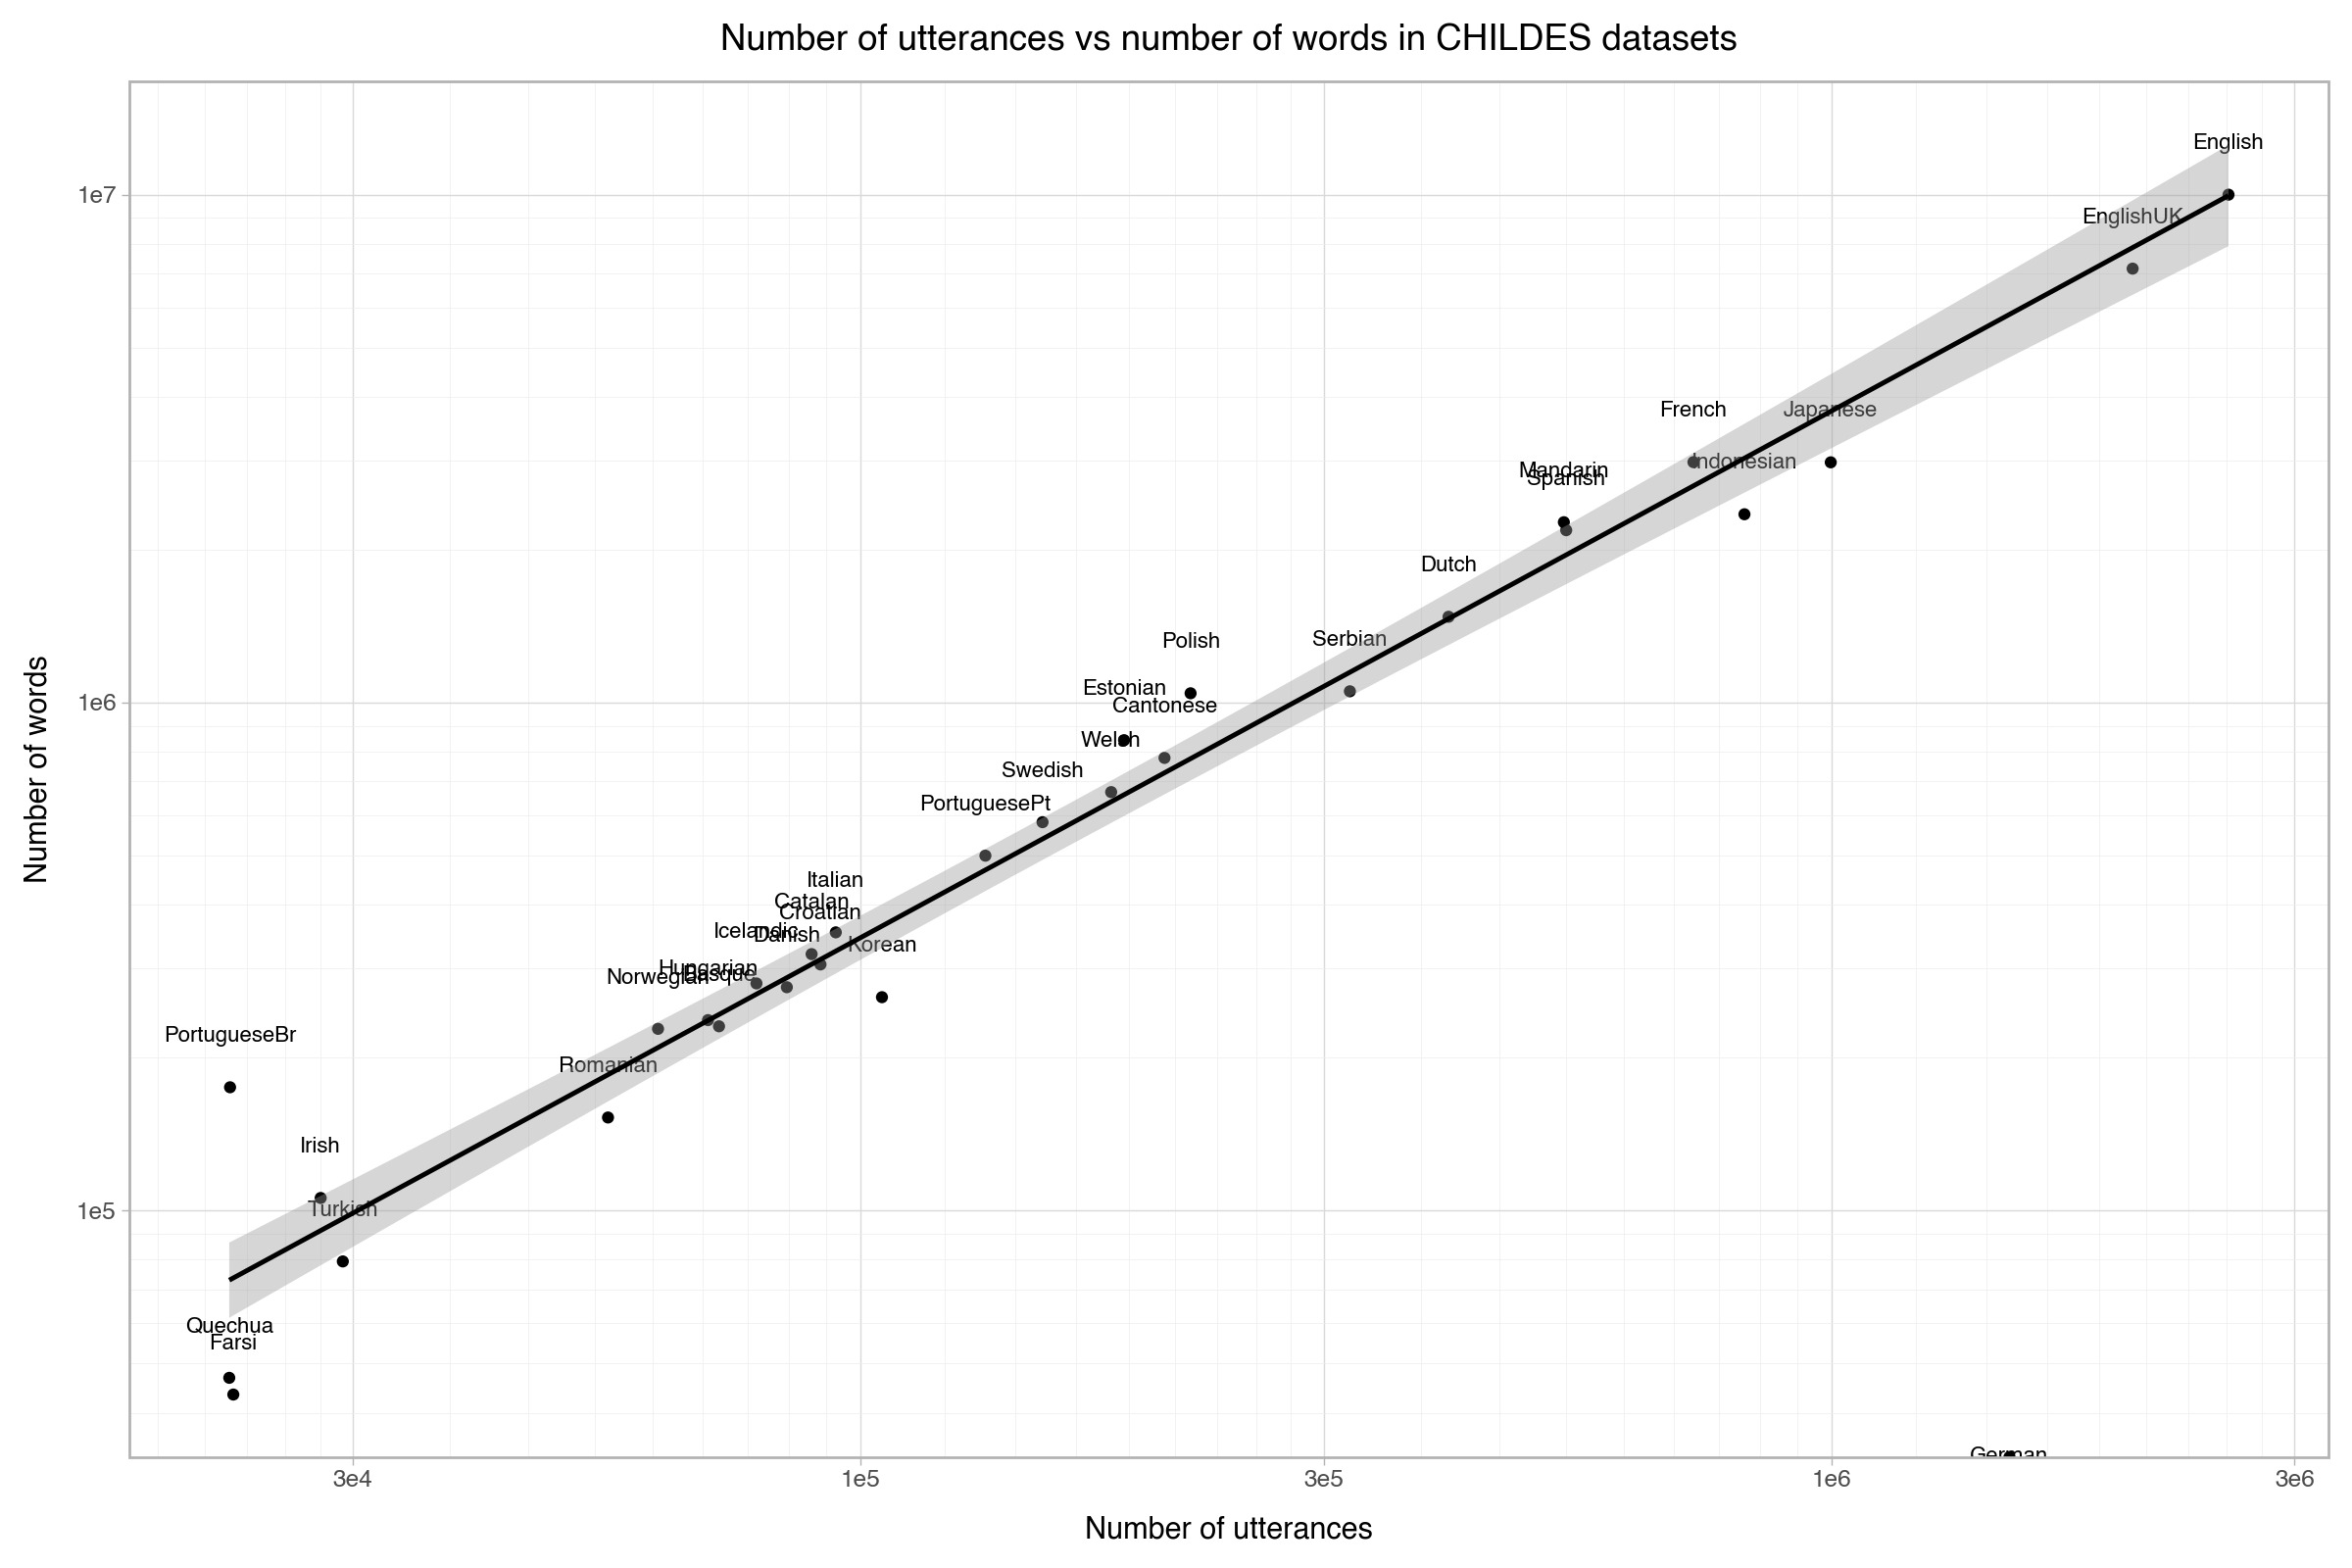

In [4]:
# Plot average utterance length as a red dashed line
gradient = properties['n_words'] / properties['n_utterances']
gradient = gradient.mean()
min_utterances = properties['n_utterances'].min()
max_utterances = properties['n_utterances'].max()

# Plot as interactive plotly plot
fig = px.scatter(properties, x='n_utterances', y='n_words', text=properties.language)
fig.update_traces(textposition='top center')
fig.update_layout(title='Number of utterances vs number of words in CHILDES datasets',
                  xaxis_title='Number of utterances',
                  yaxis_title='Number of words',
                  xaxis_type='log',
                  yaxis_type='log',
                  height=800)
fig.add_shape(type='line',
              x0=min_utterances,
              y0=min_utterances * gradient,
              x1=max_utterances,
              y1=max_utterances * gradient,
              line=dict(color='red', dash='dash', width=1))                  
fig.show()

# Plot as a p9 plot
p = (p9.ggplot(properties.reset_index(), p9.aes(x='n_utterances', y='n_words', label='language'))
     + p9.geom_point()
     + p9.geom_text(size=8, nudge_y=0.1)
     #+ p9.geom_abline(intercept=0, slope=gradient, linetype='dashed', color='red')
     + p9.geom_smooth(method='lm')
     + p9.scale_x_log10()
     + p9.scale_y_log10()
     + p9.theme(figure_size=(12, 8))
     + p9.ggtitle('Number of utterances vs number of words in CHILDES datasets')
     + p9.xlab('Number of utterances')
     + p9.ylab('Number of words')
)

p.show()


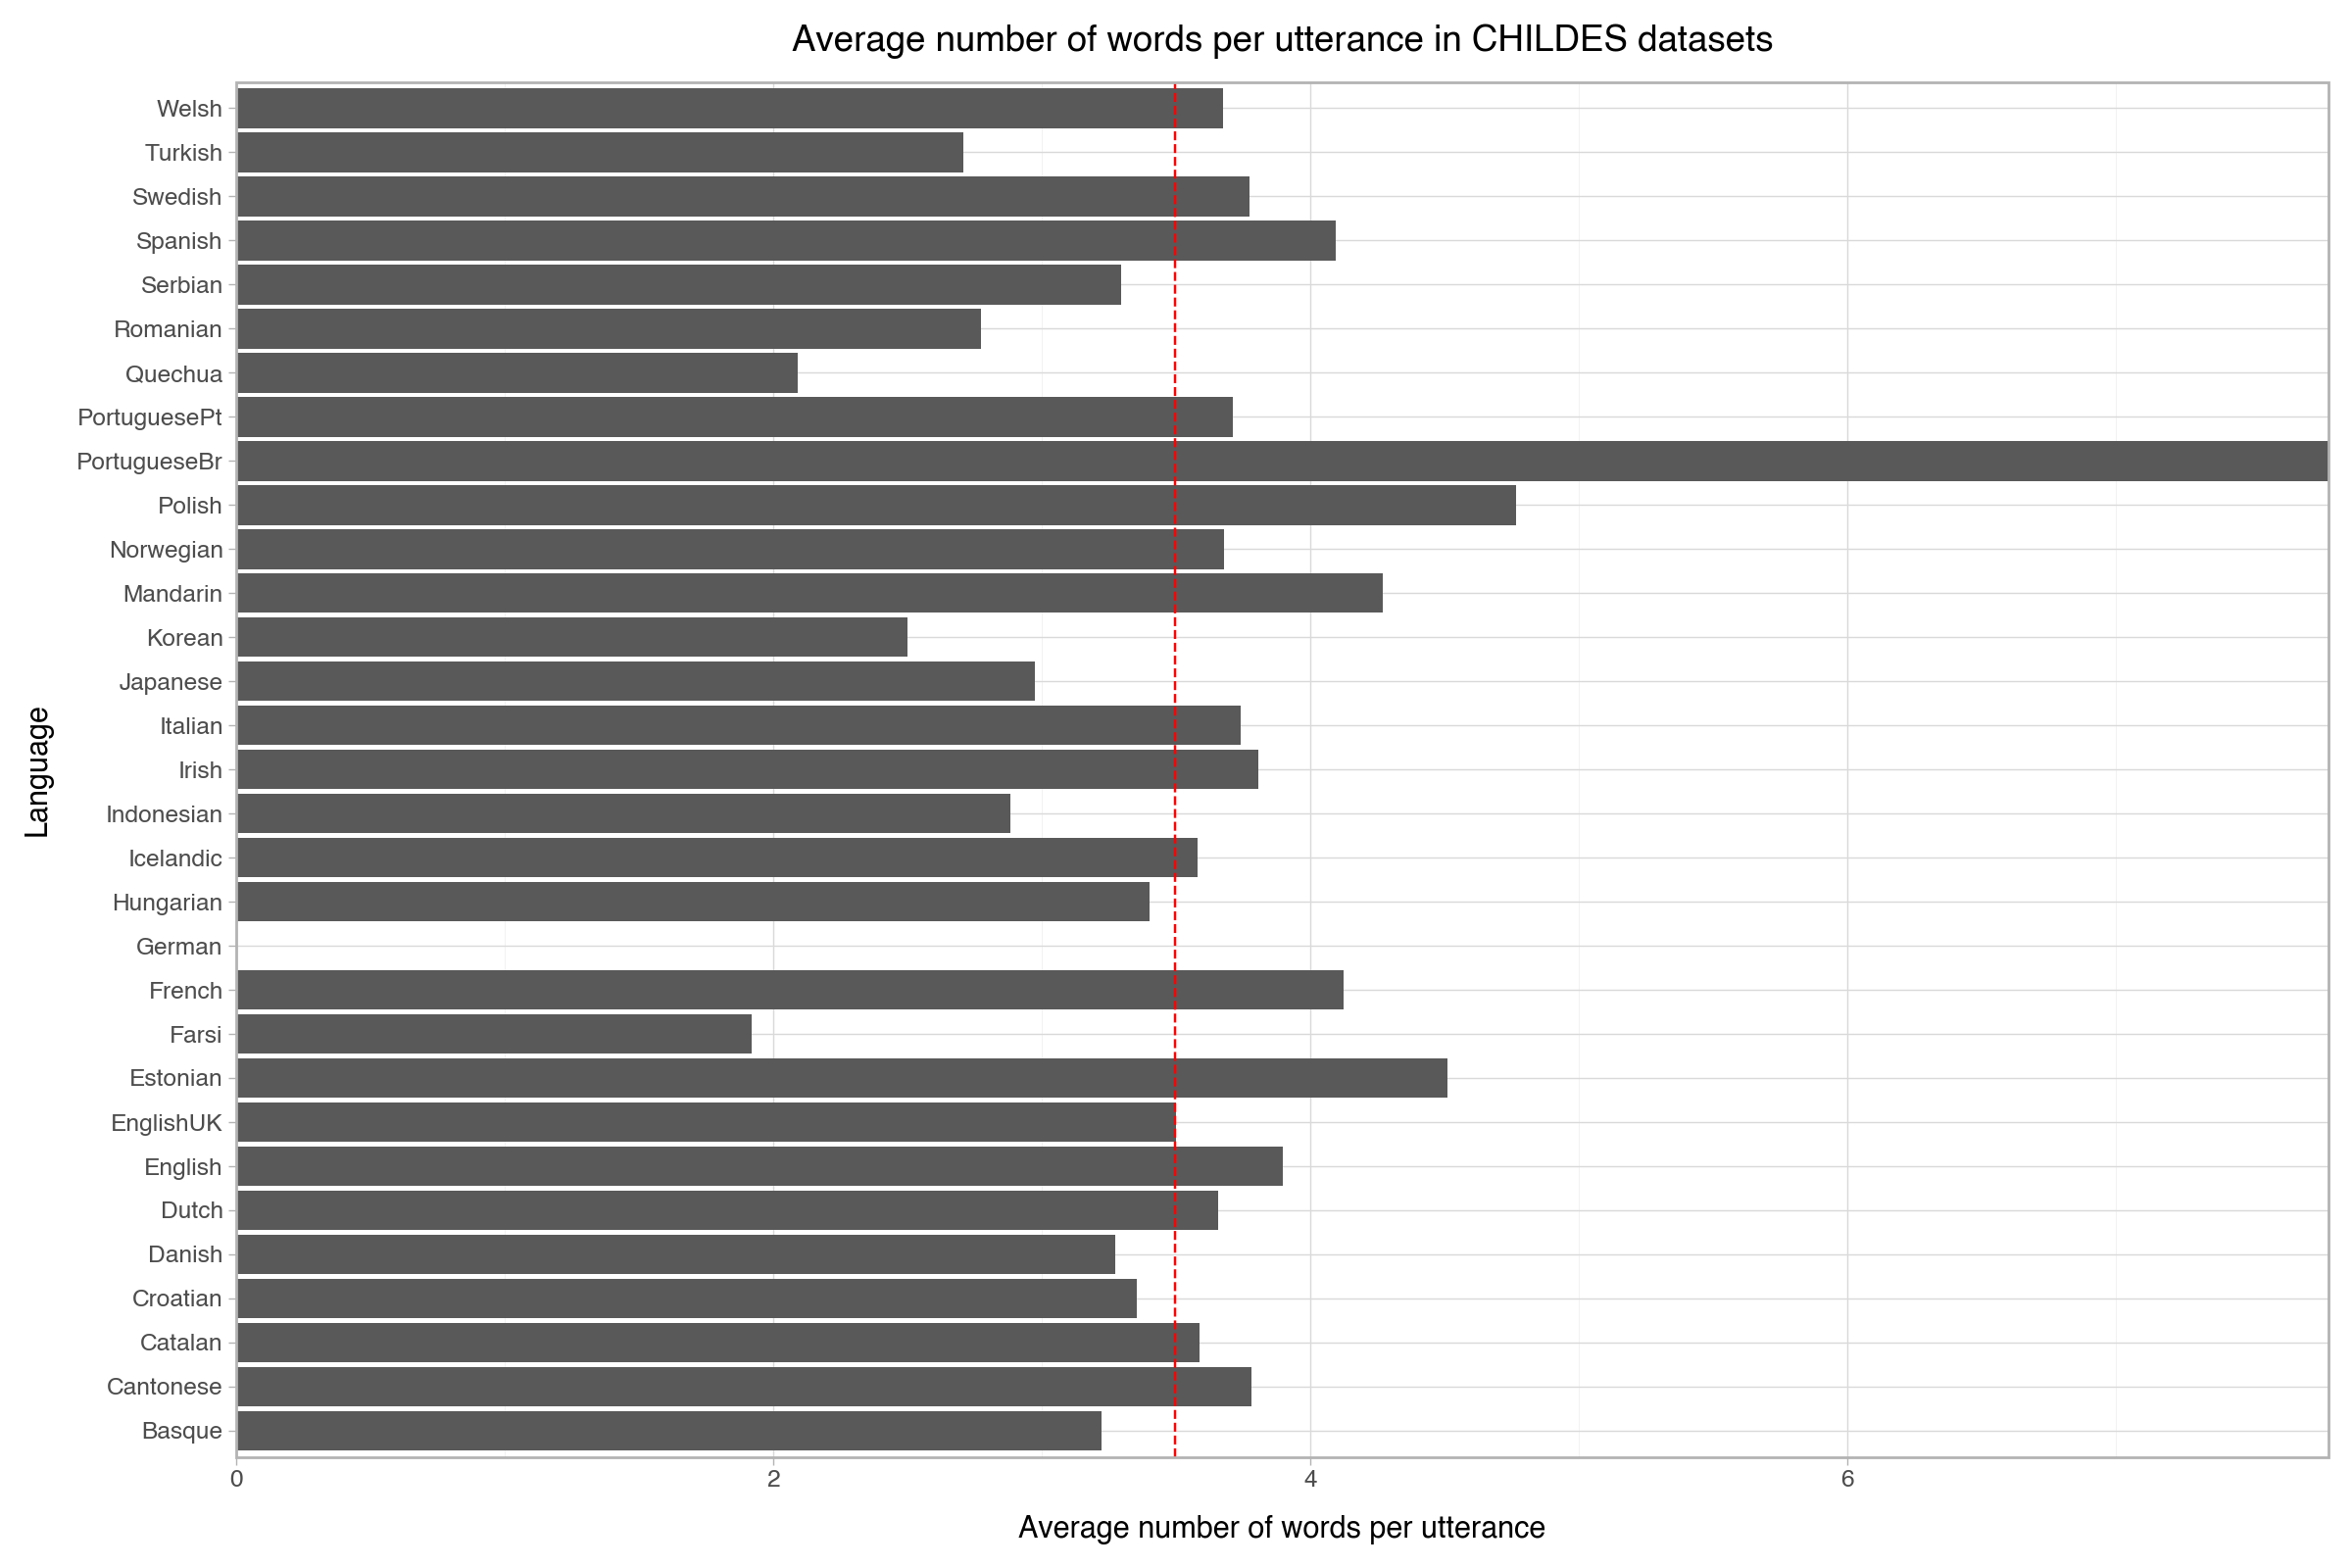

In [5]:
# Plot average length of utterances in each language

properties['average_sentence_length'] = properties['n_words'] / properties['n_utterances']
p = (p9.ggplot(properties.reset_index(), p9.aes(x='language', y='average_sentence_length'))
     + p9.geom_bar(stat='identity')
     + p9.geom_hline(yintercept=properties['average_sentence_length'].mean(), linetype='dashed', color='red')
     + p9.scale_y_continuous(limits=(0, None), expand=(0, 0))
     + p9.coord_cartesian(ylim=(0, None))
     + p9.coord_flip()
     + p9.theme(figure_size=(12, 8))
     + p9.ggtitle('Average number of words per utterance in CHILDES datasets')
     + p9.xlab('Language')
     + p9.ylab('Average number of words per utterance')
)

p.show()


/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_85329/2107694720.py:17: RuntimeWarning:

invalid value encountered in scalar multiply



/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/CorpusPhonemizers/env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log10



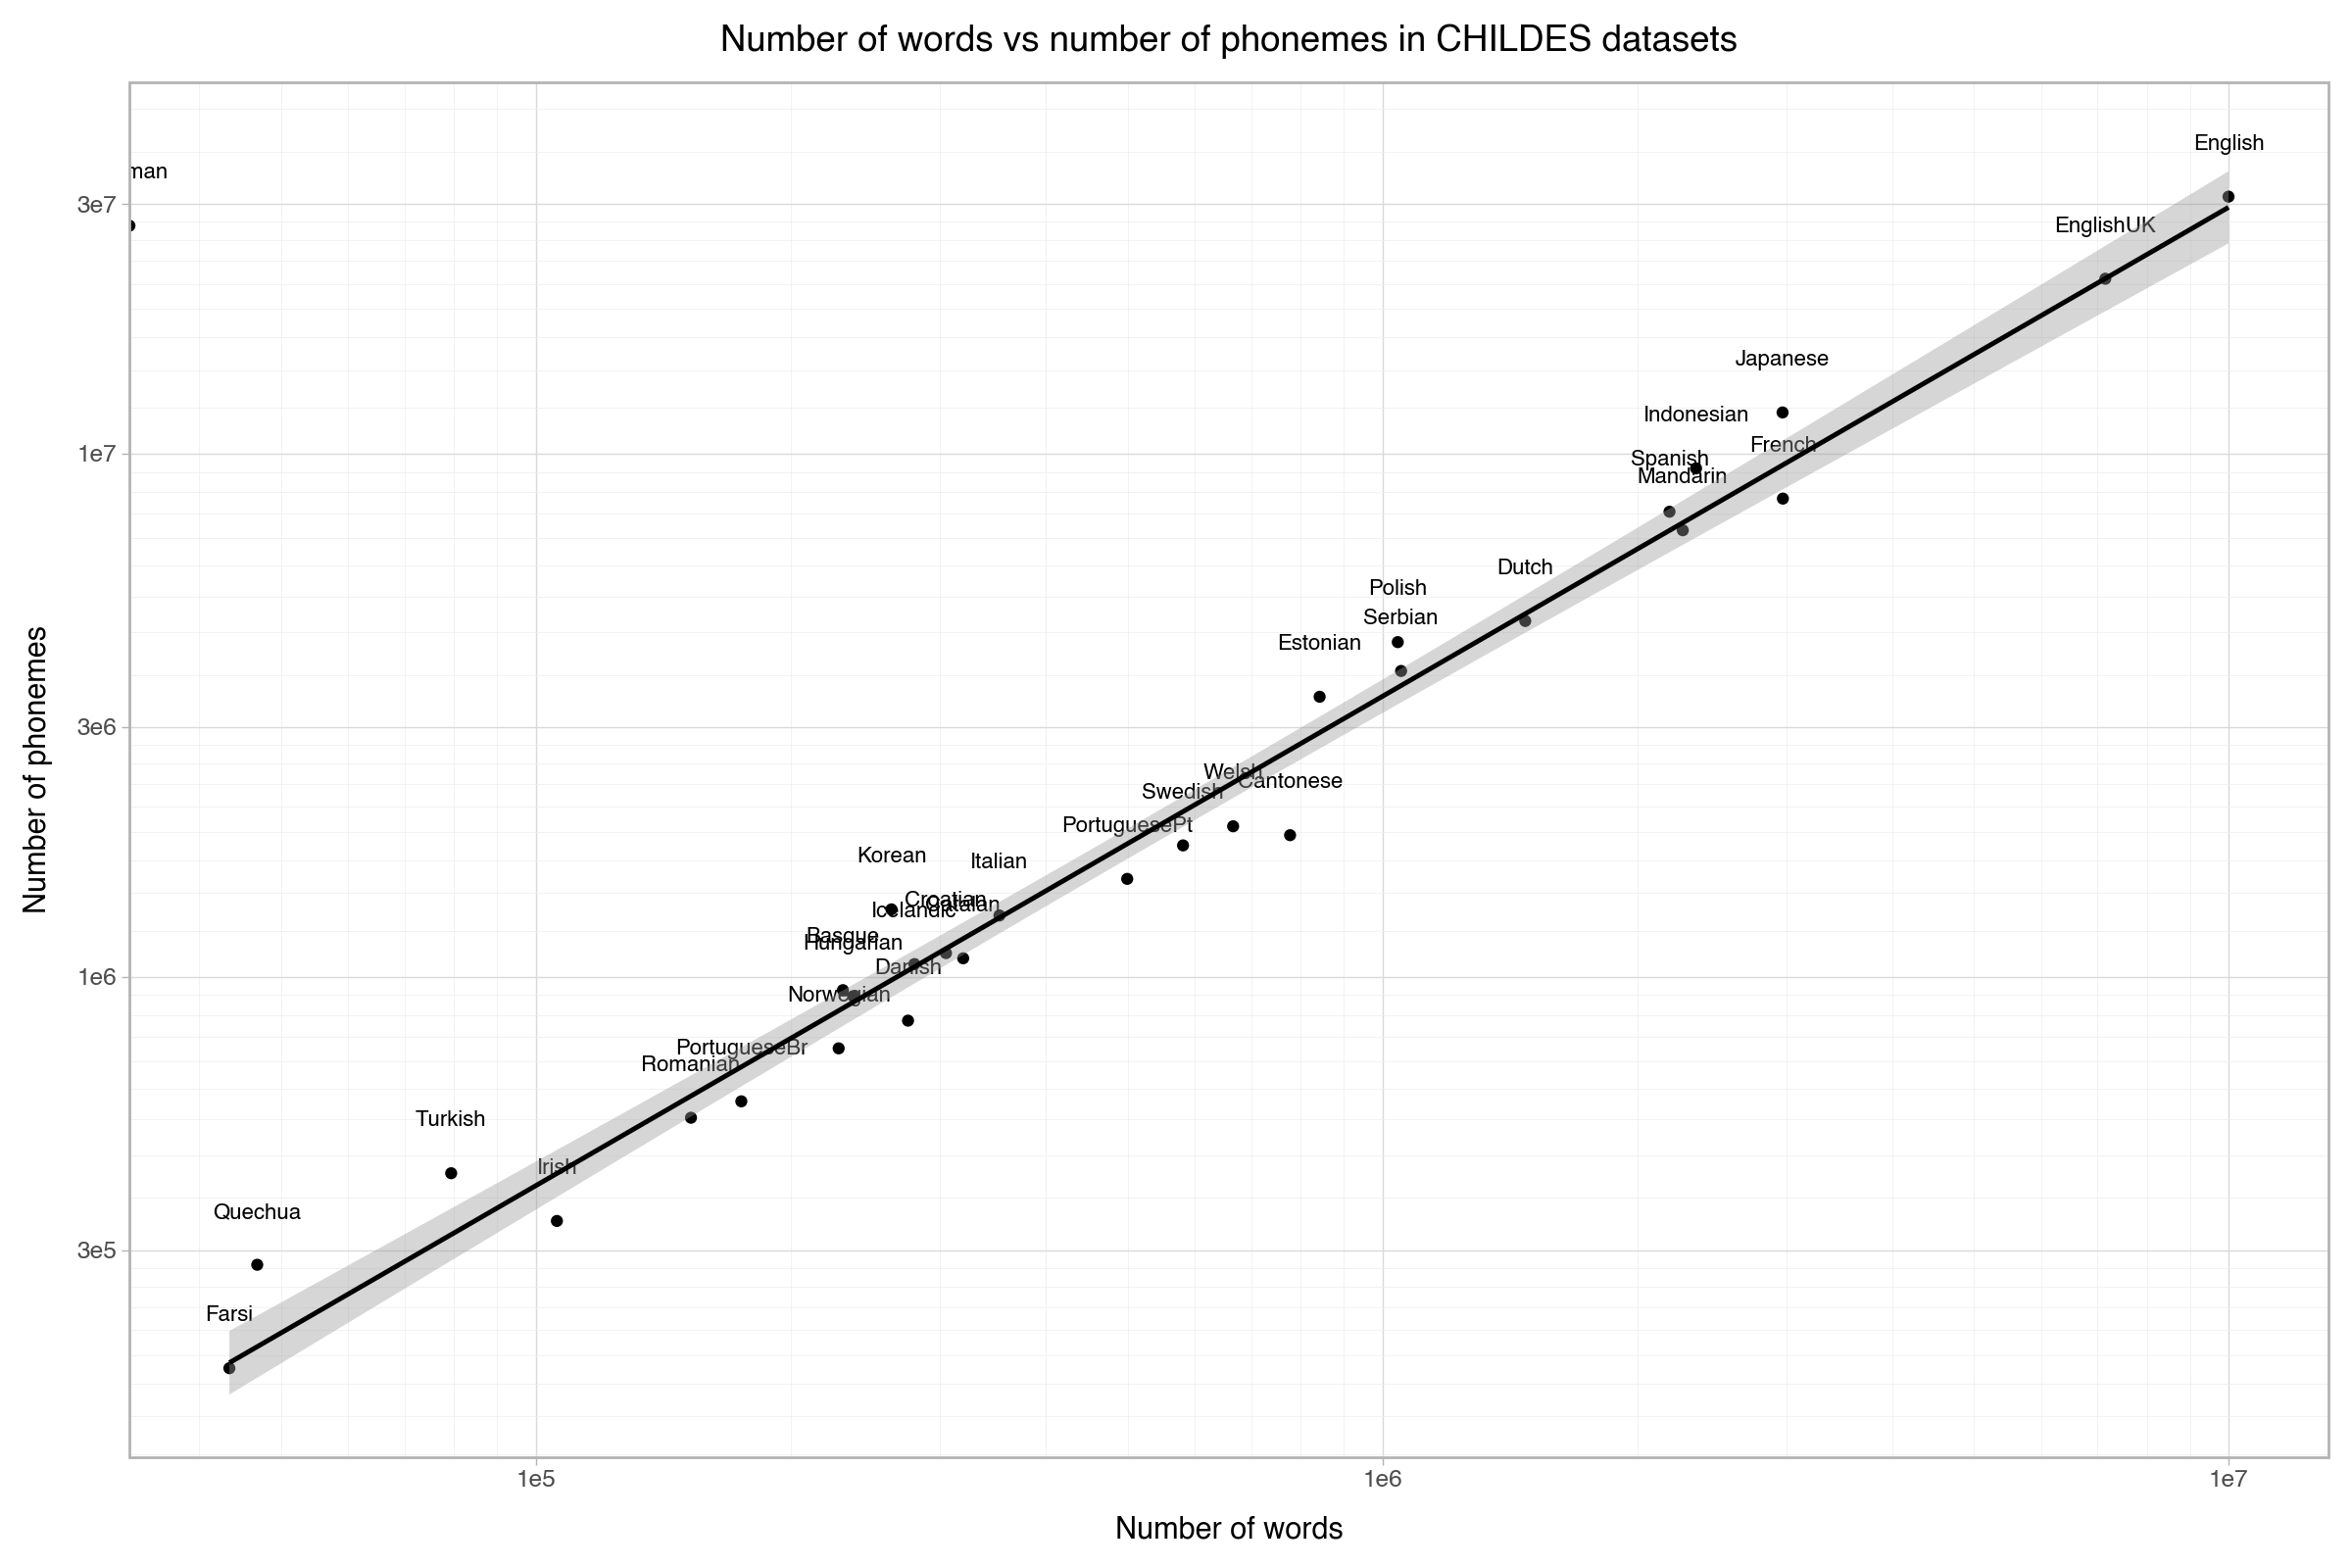

In [6]:
gradient = properties['n_phonemes'] / properties['n_words']
gradient = gradient.mean()
min_words = properties['n_words'].min()
max_words = properties['n_words'].max()

# Plot number of words against number of phonemes, with language name next to each point
fig = px.scatter(properties, x='n_words', y='n_phonemes', text=properties.language)
fig.update_traces(textposition='top center')
fig.update_layout(title='Number of words vs number of phonemes in CHILDES datasets',
                  xaxis_title='Number of words',
                  yaxis_title='Number of phonemes',
                  xaxis_type='log',
                  yaxis_type='log',
                  height=800)
fig.add_shape(type='line',
                x0=min_words,
                y0=min_words * gradient,
                x1=max_words,
                y1=max_words * gradient,
                line=dict(color='red', dash='dash', width=1))
fig.show()

# plotnine version

p = (p9.ggplot(properties.reset_index(), p9.aes(x='n_words', y='n_phonemes', label='language'))
        + p9.geom_point()
        + p9.geom_text(size=8, nudge_y=0.1)
        + p9.geom_smooth(method='lm')
        + p9.scale_x_log10()
        + p9.scale_y_log10()
        + p9.theme(figure_size=(12, 8))
        + p9.ggtitle('Number of words vs number of phonemes in CHILDES datasets')
        + p9.xlab('Number of words')
        + p9.ylab('Number of phonemes')
    )

p.show()

In [7]:
# Plot average length of words in each language
# p = (p9.ggplot(properties.reset_index(), p9.aes(x='language', y='average_word_length'))
#      + p9.geom_bar(stat='identity')
#      + p9.geom_hline(yintercept=properties['average_word_length'].mean(), linetype='dashed', color='red')
#      + p9.scale_y_continuous(limits=(0, None), expand=(0, 0))
#      + p9.coord_cartesian(ylim=(0, None))
#      + p9.coord_flip()
#      + p9.theme(figure_size=(12, 8))
#      + p9.ggtitle('Average word length in CHILDES datasets')
#      + p9.xlab('Language')
#      + p9.ylab('Average word length (phonemes)')
# )

# p.show()


## Language Properties

In [8]:
properties = properties.sort_values('n_utterances', ascending=True)
properties

,language,n_utterances,n_words,n_phonemes,unique_words,average_sentence_length
23,Quechua,22397,46848,281478,9275,2.091709
27,PortugueseBr,22439,174845,577865,7127,7.792014
15,Farsi,22613,43432,178523,4778,1.920665
18,Irish,27818,105867,341343,4406,3.805701
14,Turkish,29317,79404,421129,10597,2.708463
28,Romanian,54982,152465,537669,7024,2.772998
22,Norwegian,61906,227856,729649,10371,3.680677
13,Hungarian,69690,237062,918002,20738,3.401665
12,Basque,71537,230500,942725,17291,3.222109
16,Icelandic,78181,279939,1057235,12860,3.580653


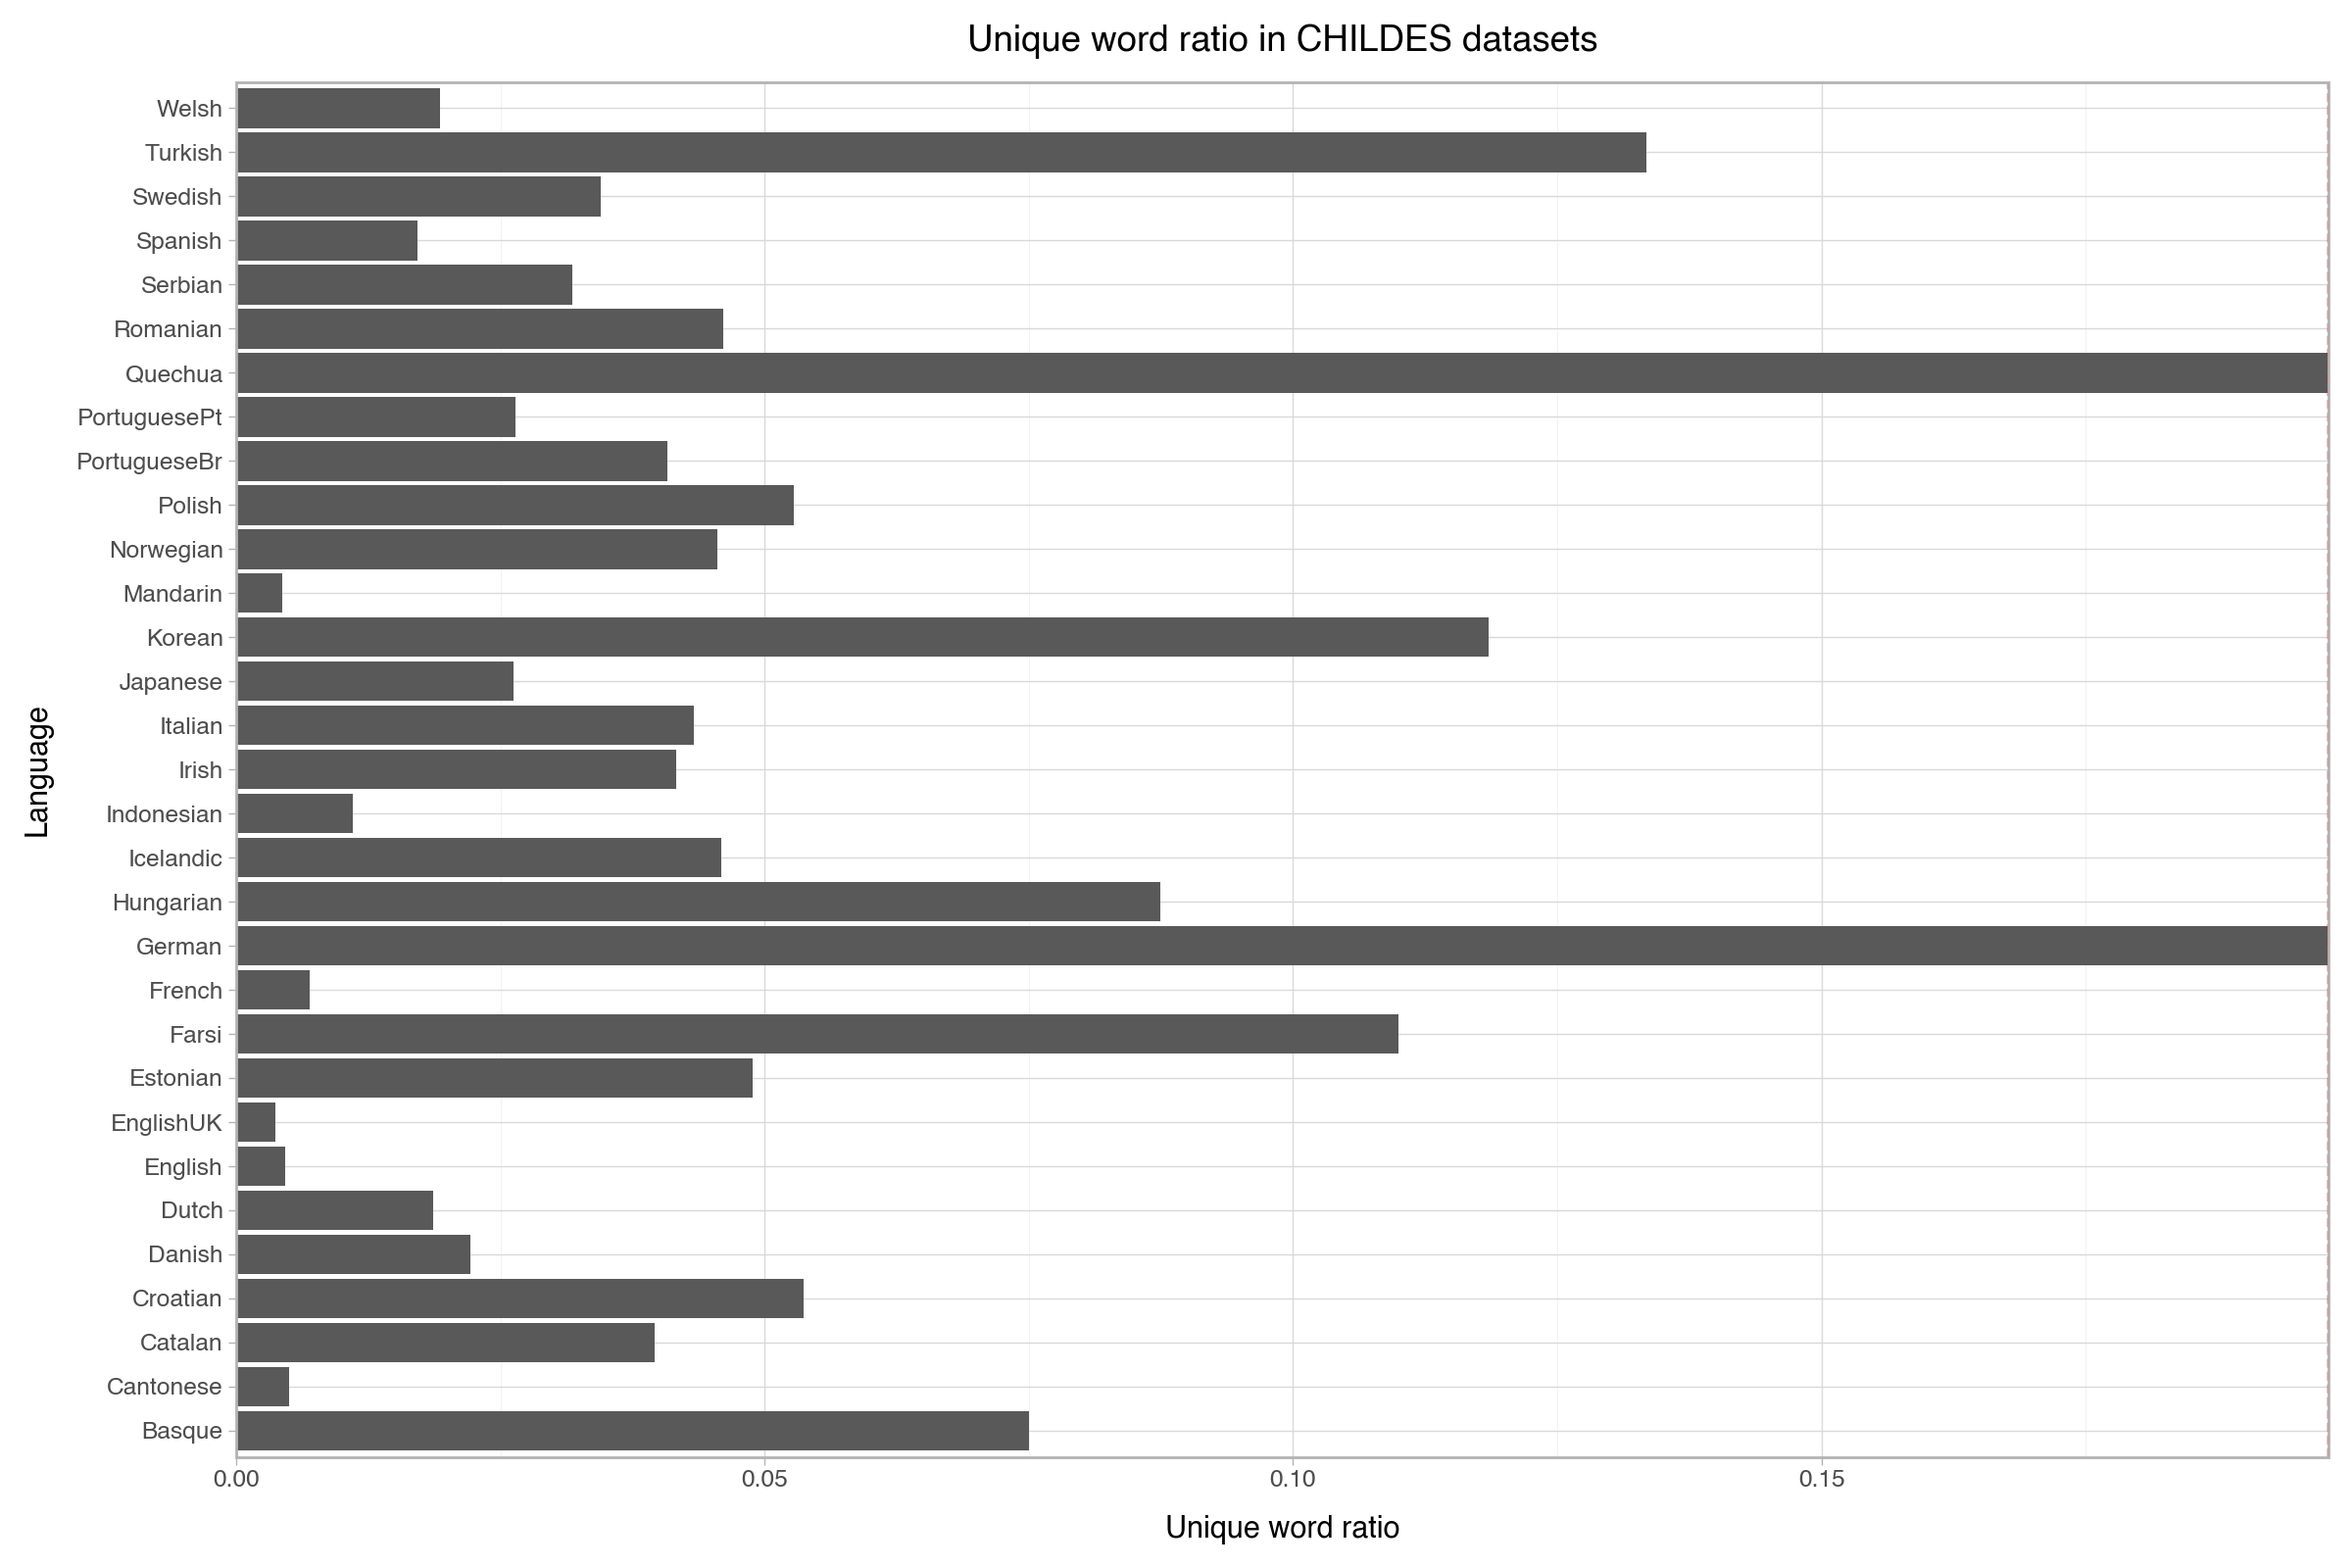

In [9]:
# Plot the ratio of unique words to words in each language
properties['unique_word_ratio'] = properties['unique_words'] / properties['n_words']
#properties = properties.sort_values('language', ascending=False)
#properties['language'] = pd.Categorical(properties['language'], categories=properties.sort_values('n_words', ascending=True)['language'], ordered=True)

p = (p9.ggplot(properties, p9.aes(x='language', y='unique_word_ratio'))
     + p9.geom_bar(stat='identity')
     + p9.geom_hline(yintercept=properties['unique_word_ratio'].mean(), linetype='dashed', color='red')
     + p9.scale_y_continuous(limits=(0, None), expand=(0, 0))
     + p9.coord_flip()
     + p9.theme(figure_size=(12, 8))
     + p9.ggtitle('Unique word ratio in CHILDES datasets')
     + p9.xlab('Language')
     + p9.ylab('Unique word ratio')
)

p.show()



In [10]:
# Plot heap's law for English
english = datasets['English']
lines = list(english['phonemized_utterance'])
np.random.shuffle(lines)
n_words = []
unique_words = []
vocabulary = set()
total_words = 0
for i, line in enumerate(tqdm(lines)):
    words = [word.strip() for word in line.split('WORD_BOUNDARY') if word.strip() != '']
    total_words += len(words)
    n_words.append(total_words)
    vocabulary.update(words)
    unique_words.append(len(vocabulary))

100%|██████████| 2564614/2564614 [00:03<00:00, 656144.39it/s]


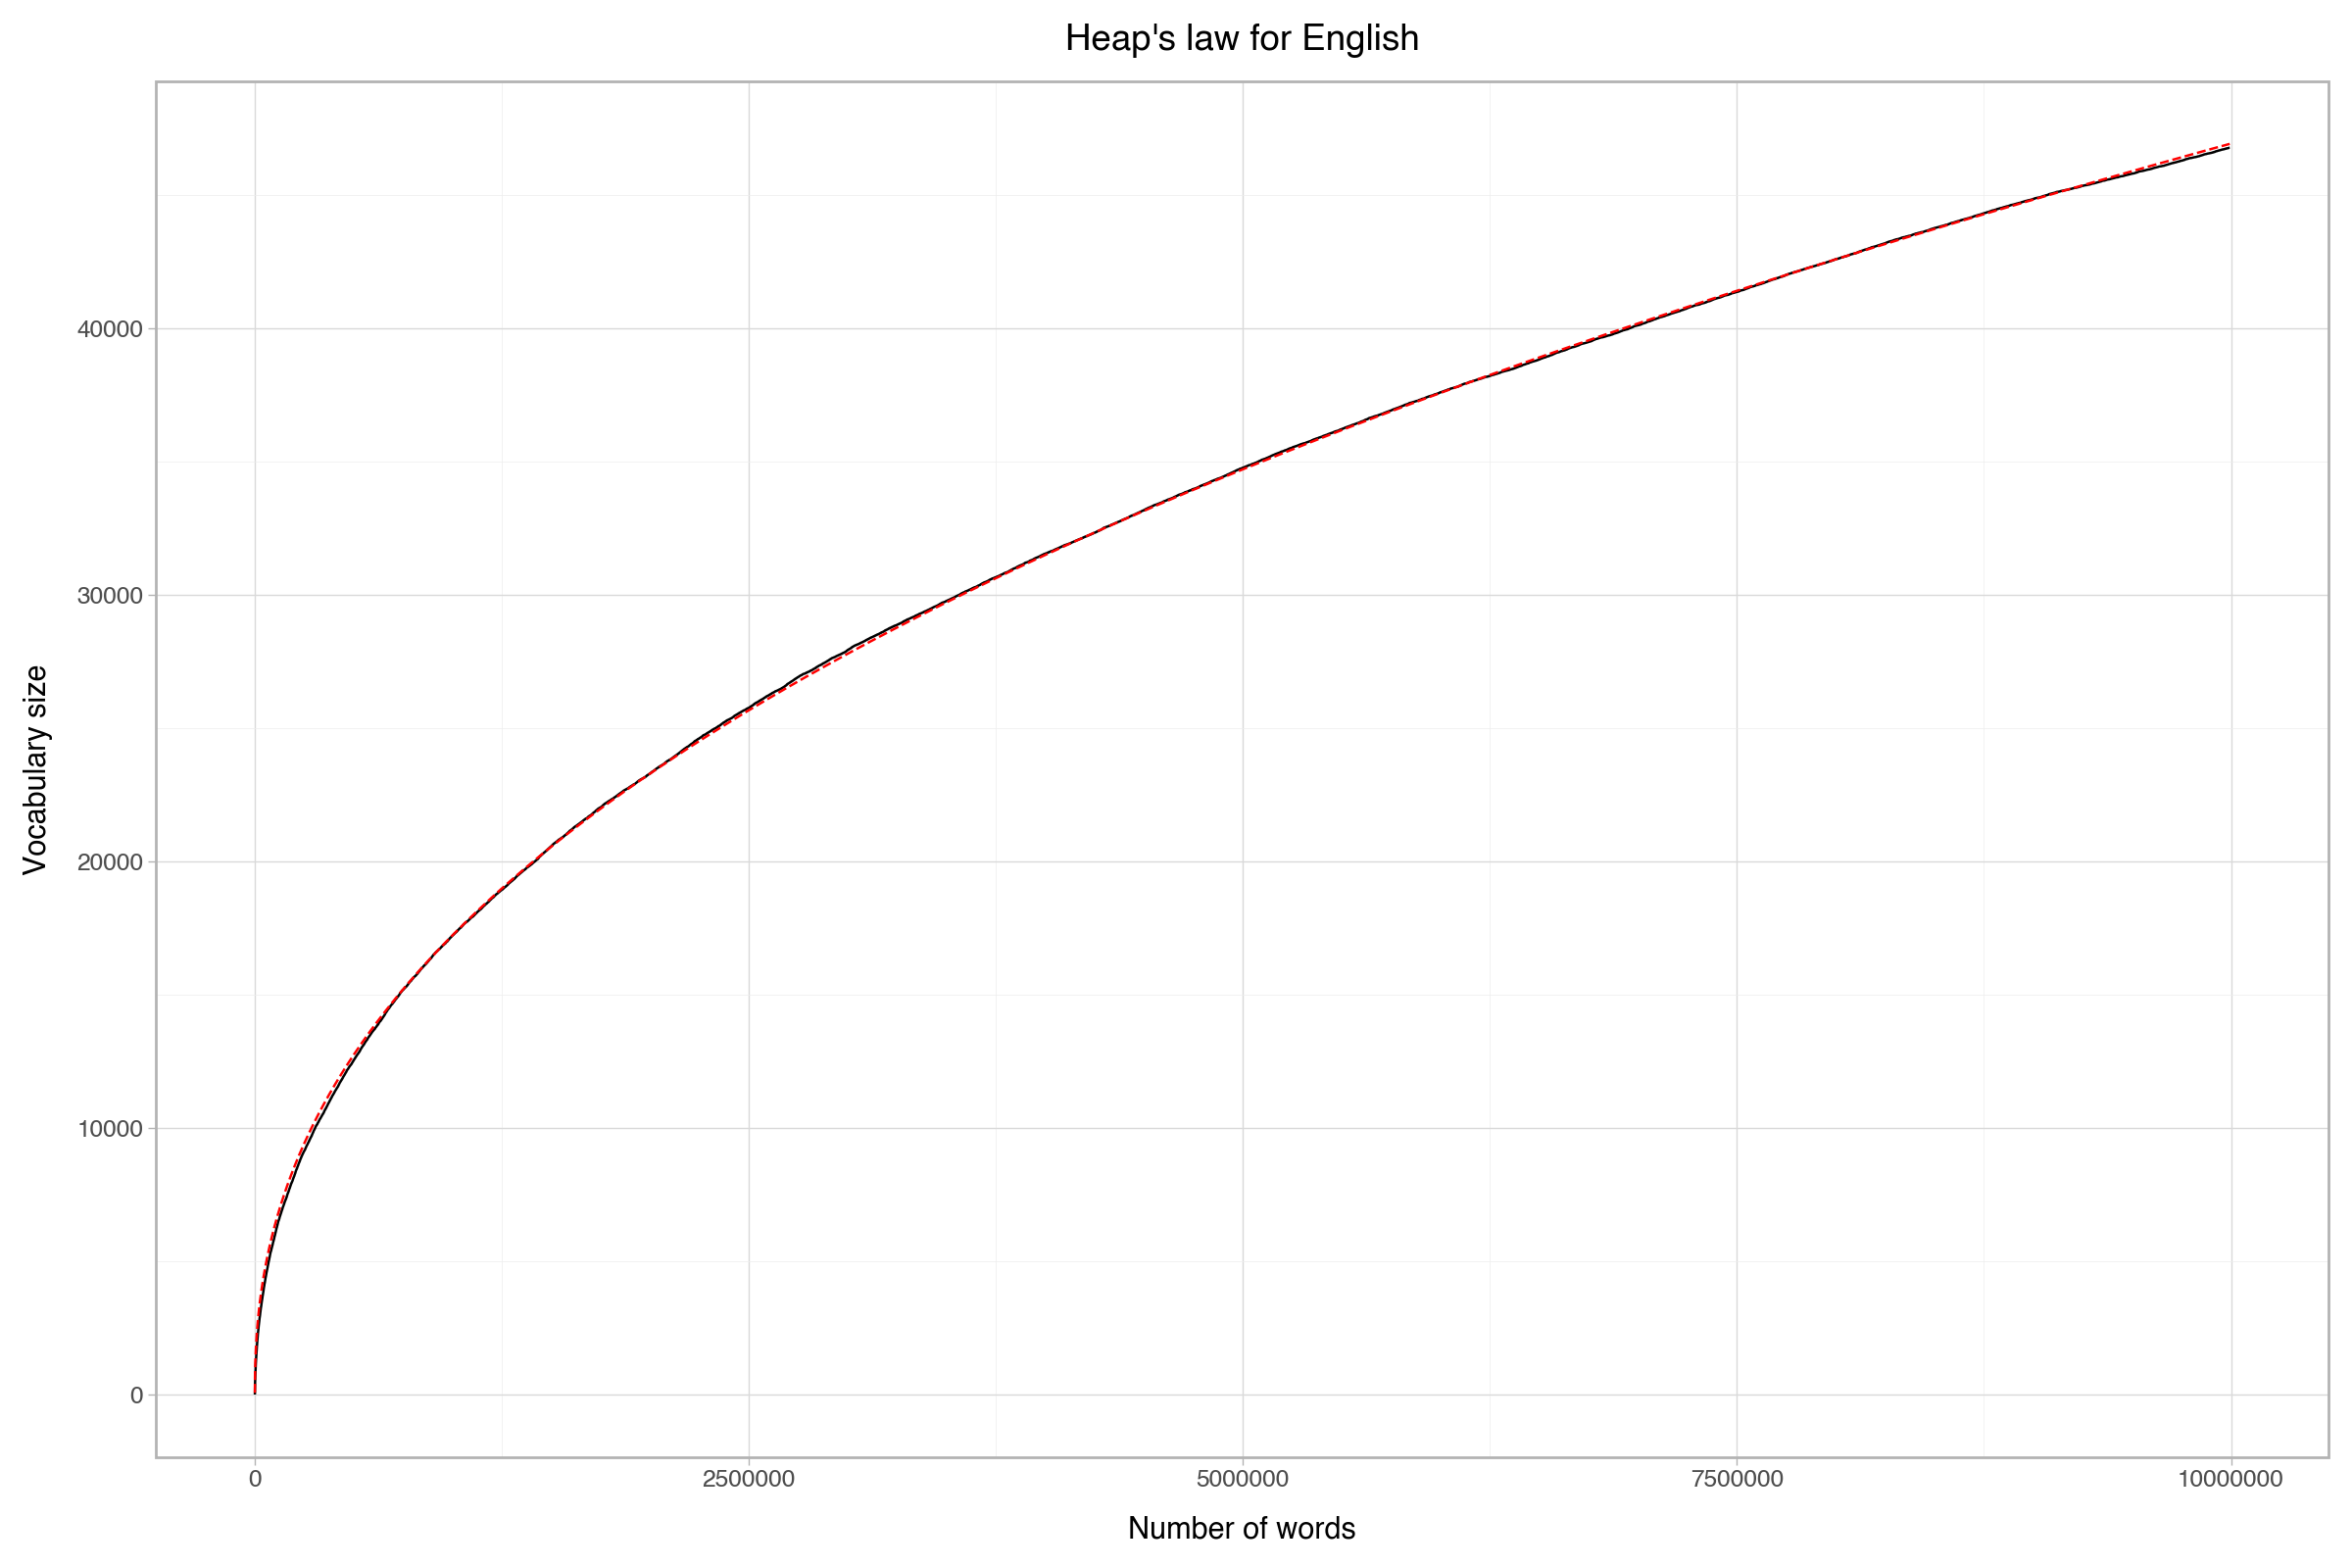

In [11]:
# Fit a power law to the data
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a * np.power(x, b)

popt, pcov = curve_fit(power_law, n_words, unique_words)
a, b = popt
# plt.figure(figsize=(10, 5))
# plt.plot(n_words, unique_words)
# plt.plot(n_words, power_law(n_words, a, b), color='red', linestyle='--')
# plt.xlabel('Number of words')
# plt.ylabel('Vocabulary size')
# plt.title("Heap's law for English")
# plt.show()

# print(f'Heap\'s law for English: V = {a:.2f} * N^{b:.2f}')

# Plot using plotnine
heap_data = pd.DataFrame({'n_words': n_words, 'unique_words': unique_words})
heap_data['fitted'] = power_law(heap_data['n_words'], a, b)

p = (p9.ggplot(heap_data, p9.aes(x='n_words', y='unique_words'))
        + p9.geom_line()
        + p9.geom_line(p9.aes(y='fitted'), color='red', linetype='dashed')
        + p9.theme(figure_size=(12, 8))
        + p9.ggtitle("Heap's law for English")
        + p9.xlab('Number of words')
        + p9.ylab('Vocabulary size')
    )

p.show()


In [12]:
# # Plot heaps law for all languages
# heap_parameters = {}
# plt.figure(figsize=(20, 10))
# for language, dataset in datasets.items():
#     lines = list(dataset['phonemized_utterance'])
#     np.random.shuffle(lines)
#     n_words = []
#     unique_words = []
#     vocabulary = set()
#     total_words = 0
#     for i, line in enumerate(lines):
#         words = [word.strip() for word in line.split('WORD_BOUNDARY') if word.strip() != '']
#         total_words += len(words)
#         n_words.append(total_words)
#         vocabulary.update(words)
#         unique_words.append(len(vocabulary))
#     plt.plot(n_words, unique_words, label=language)

#     # Fit a power law to the data
#     popt, pcov = curve_fit(power_law, n_words, unique_words)
#     a, b = popt
#     heap_parameters[language] = (a, b)
#     print(f'Heap\'s law for {language}: V = {a:.2f} * N^{b:.2f}')

# plt.xlabel('Number of words')
# plt.ylabel('Vocabulary size')
# # Make legend two columns
# plt.legend(ncol=3)
# plt.title("Heap's law for all languages")
# plt.show()

# Now with plotnine
# heap_data = pd.DataFrame(columns=['language', 'n_words', 'unique_words'])
# for language, dataset in datasets.items():
#     lines = list(dataset['phonemized_utterance'])
#     np.random.shuffle(lines)
#     n_words = []
#     unique_words = []
#     vocabulary = set()
#     total_words = 0
#     for i, line in enumerate(lines):
#         words = [word.strip() for word in line.split('WORD_BOUNDARY') if word.strip() != '']
#         total_words += len(words)
#         n_words.append(total_words)
#         vocabulary.update(words)
#         unique_words.append(len(vocabulary))
#     heap_data = pd.concat([heap_data, pd.DataFrame({'language': language, 'n_words': n_words, 'unique_words': unique_words})], ignore_index=True)

# p = (p9.ggplot(heap_data, p9.aes(x='n_words', y='unique_words', color='language'))
#         + p9.geom_line()
#         + p9.theme(figure_size=(12, 8))
#         + p9.ggtitle("Heap's law for all languages")
#         + p9.xlab('Number of words')
#         + p9.ylab('Vocabulary size')
#     )

# p.show()

## Information content

In [13]:
phoneme_frequencies = {}
totals = {}
for language, dataset in datasets.items():
    lines = list(dataset['phonemized_utterance'])
    phonemes = [phoneme for line in lines for phoneme in line.split(' ')]
    phoneme_frequencies[language] = pd.Series(phonemes).value_counts()
    phoneme_frequencies[language] = phoneme_frequencies[language][phoneme_frequencies[language] > 100]
    totals[language] = phoneme_frequencies[language].sum()

def word_information(word, language):
    # Estimate the information content of a word using the phoneme frequencies
    phonemes = word.split(' ')
    information = 0
    for phoneme in phonemes:
        if phoneme in phoneme_frequencies[language]:
            p = phoneme_frequencies[language][phoneme] / totals[language]
            information += -np.log2(p)
    return information

# Calculate the information content of each word in each language
information_content = {}
for language, dataset in tqdm(datasets.items()):
    lines = list(dataset['phonemized_utterance'])
    np.random.shuffle(lines)
    lines = lines[:10000]
    words = [word.strip() for line in lines for word in line.split('WORD_BOUNDARY') if word.strip() != '']
    information_content[language] = [word_information(word, language) for word in words]


100%|██████████| 31/31 [00:17<00:00,  1.75it/s]


In [14]:
# Remove top 5% of information content values for each language
for language in information_content:
    percentile = np.percentile(information_content[language], 95)
    information_content[language] = [i for i in information_content[language] if i <= percentile]

In [15]:
# Plot information content of words in each language
information_data = pd.DataFrame({'language': [language for language in information_content for _ in information_content[language]],
                                    'information': [info for infos in information_content.values() for info in infos]})
p = (p9.ggplot(information_data, p9.aes(x='language', y='information'))
        + p9.geom_density()
        + p9.coord_flip()
        + p9.theme(figure_size=(12, 8))
        + p9.ggtitle('Information content of words in CHILDES datasets')
        + p9.xlab('Language')
        + p9.ylab('Information content (bits)')
    )

p.show()

KeyError: 'y'

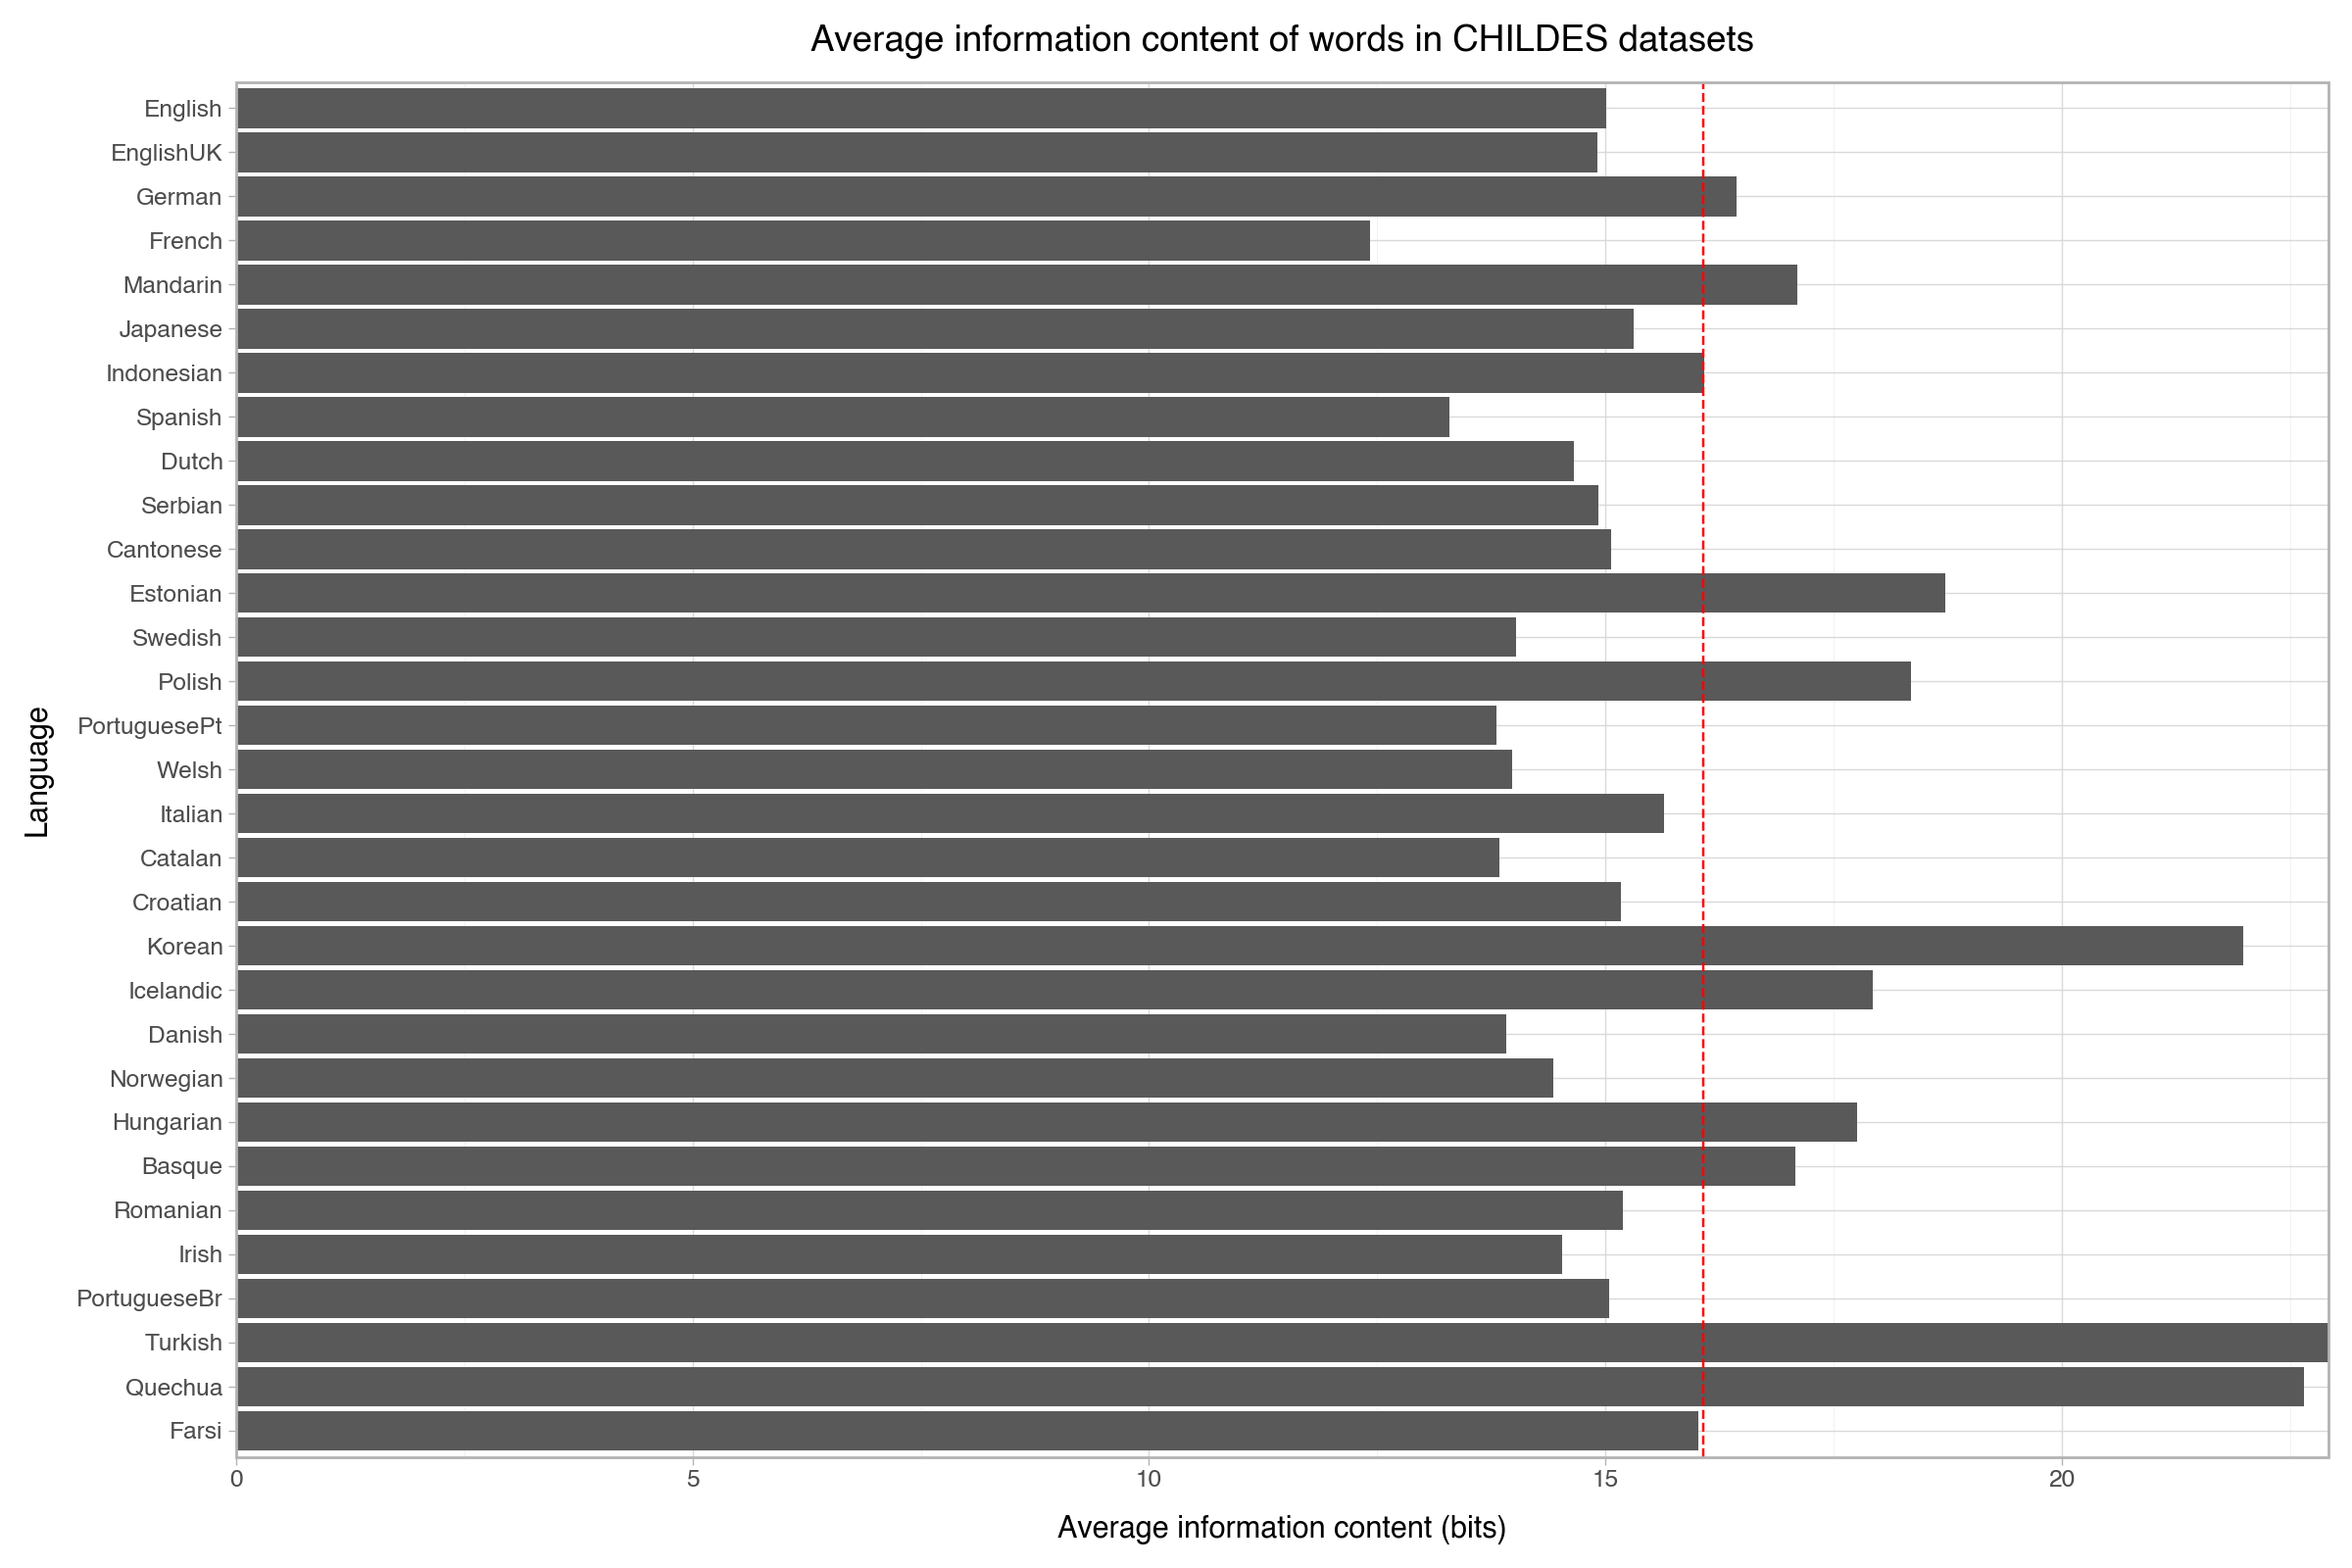

In [117]:
# Plot average information content of words in each language
properties['average_information_content'] = [np.mean(information_content[language]) for language in properties.language]

p = (p9.ggplot(properties.reset_index(), p9.aes(x='language', y='average_information_content'))
     + p9.geom_bar(stat='identity')
     + p9.geom_hline(yintercept=properties['average_information_content'].mean(), linetype='dashed', color='red')
     + p9.scale_y_continuous(limits=(0, None), expand=(0, 0))
     + p9.coord_flip()
     + p9.theme(figure_size=(12, 8))
     + p9.ggtitle('Average information content of words in CHILDES datasets')
     + p9.xlab('Language')
     + p9.ylab('Average information content (bits)')
)

p.show()

100%|██████████| 31/31 [00:19<00:00,  1.56it/s]


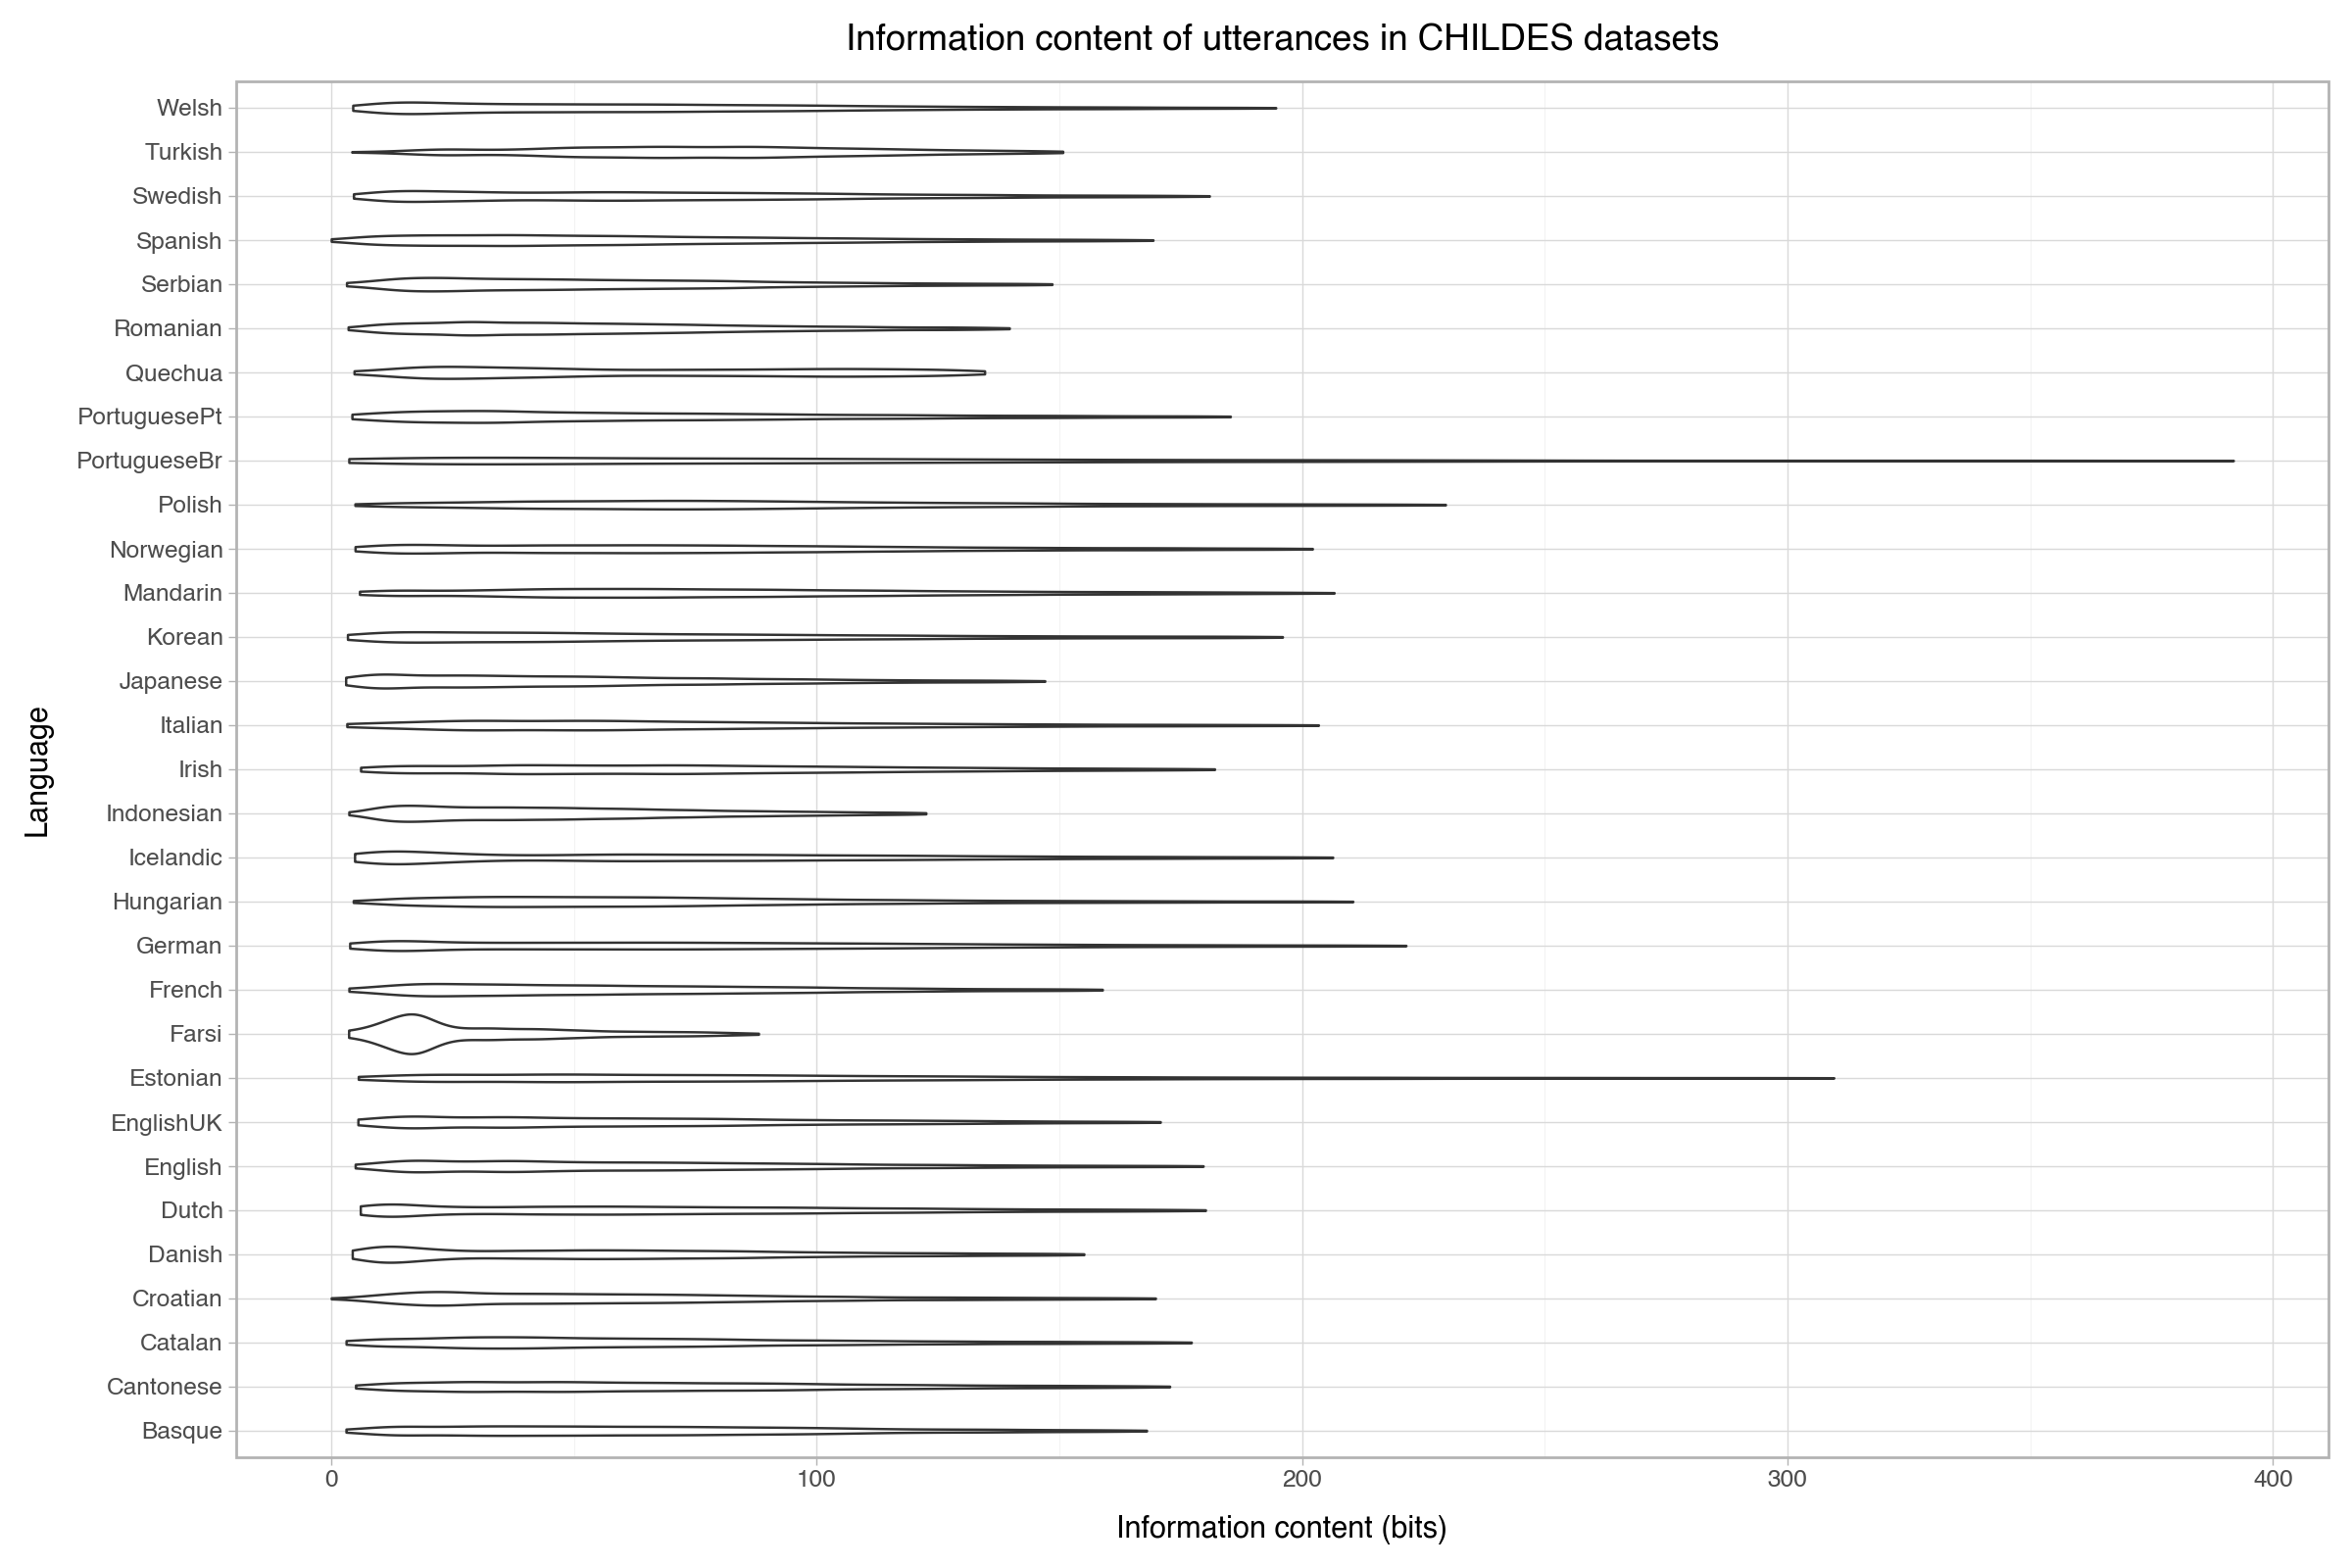

In [119]:
# Calculate the information content of each utterance in each language
information_content = {}
for language, dataset in tqdm(datasets.items()):
    lines = list(dataset['phonemized_utterance'])
    lines = [line.replace(' WORD_BOUNDARY', '') for line in lines]
    np.random.shuffle(lines)
    lines = lines[:10000]
    information_content[language] = [word_information(line, language) for line in lines]

# Remove top 5% of information content values for each language
for language in information_content:
    percentile = np.percentile(information_content[language], 95)
    information_content[language] = [i for i in information_content[language] if i <= percentile]

# Plot the information content of utterances in each language
p = (p9.ggplot(pd.DataFrame({'language': [language for language in information_content for _ in information_content[language]],
                             'information': [info for infos in information_content.values() for info in infos]}),
               p9.aes(x='language', y='information'))
     + p9.geom_violin()
     + p9.coord_flip()
     + p9.theme(figure_size=(12, 8))
     + p9.ggtitle('Information content of utterances in CHILDES datasets')
     + p9.xlab('Language')
     + p9.ylab('Information content (bits)')
)

p.show()


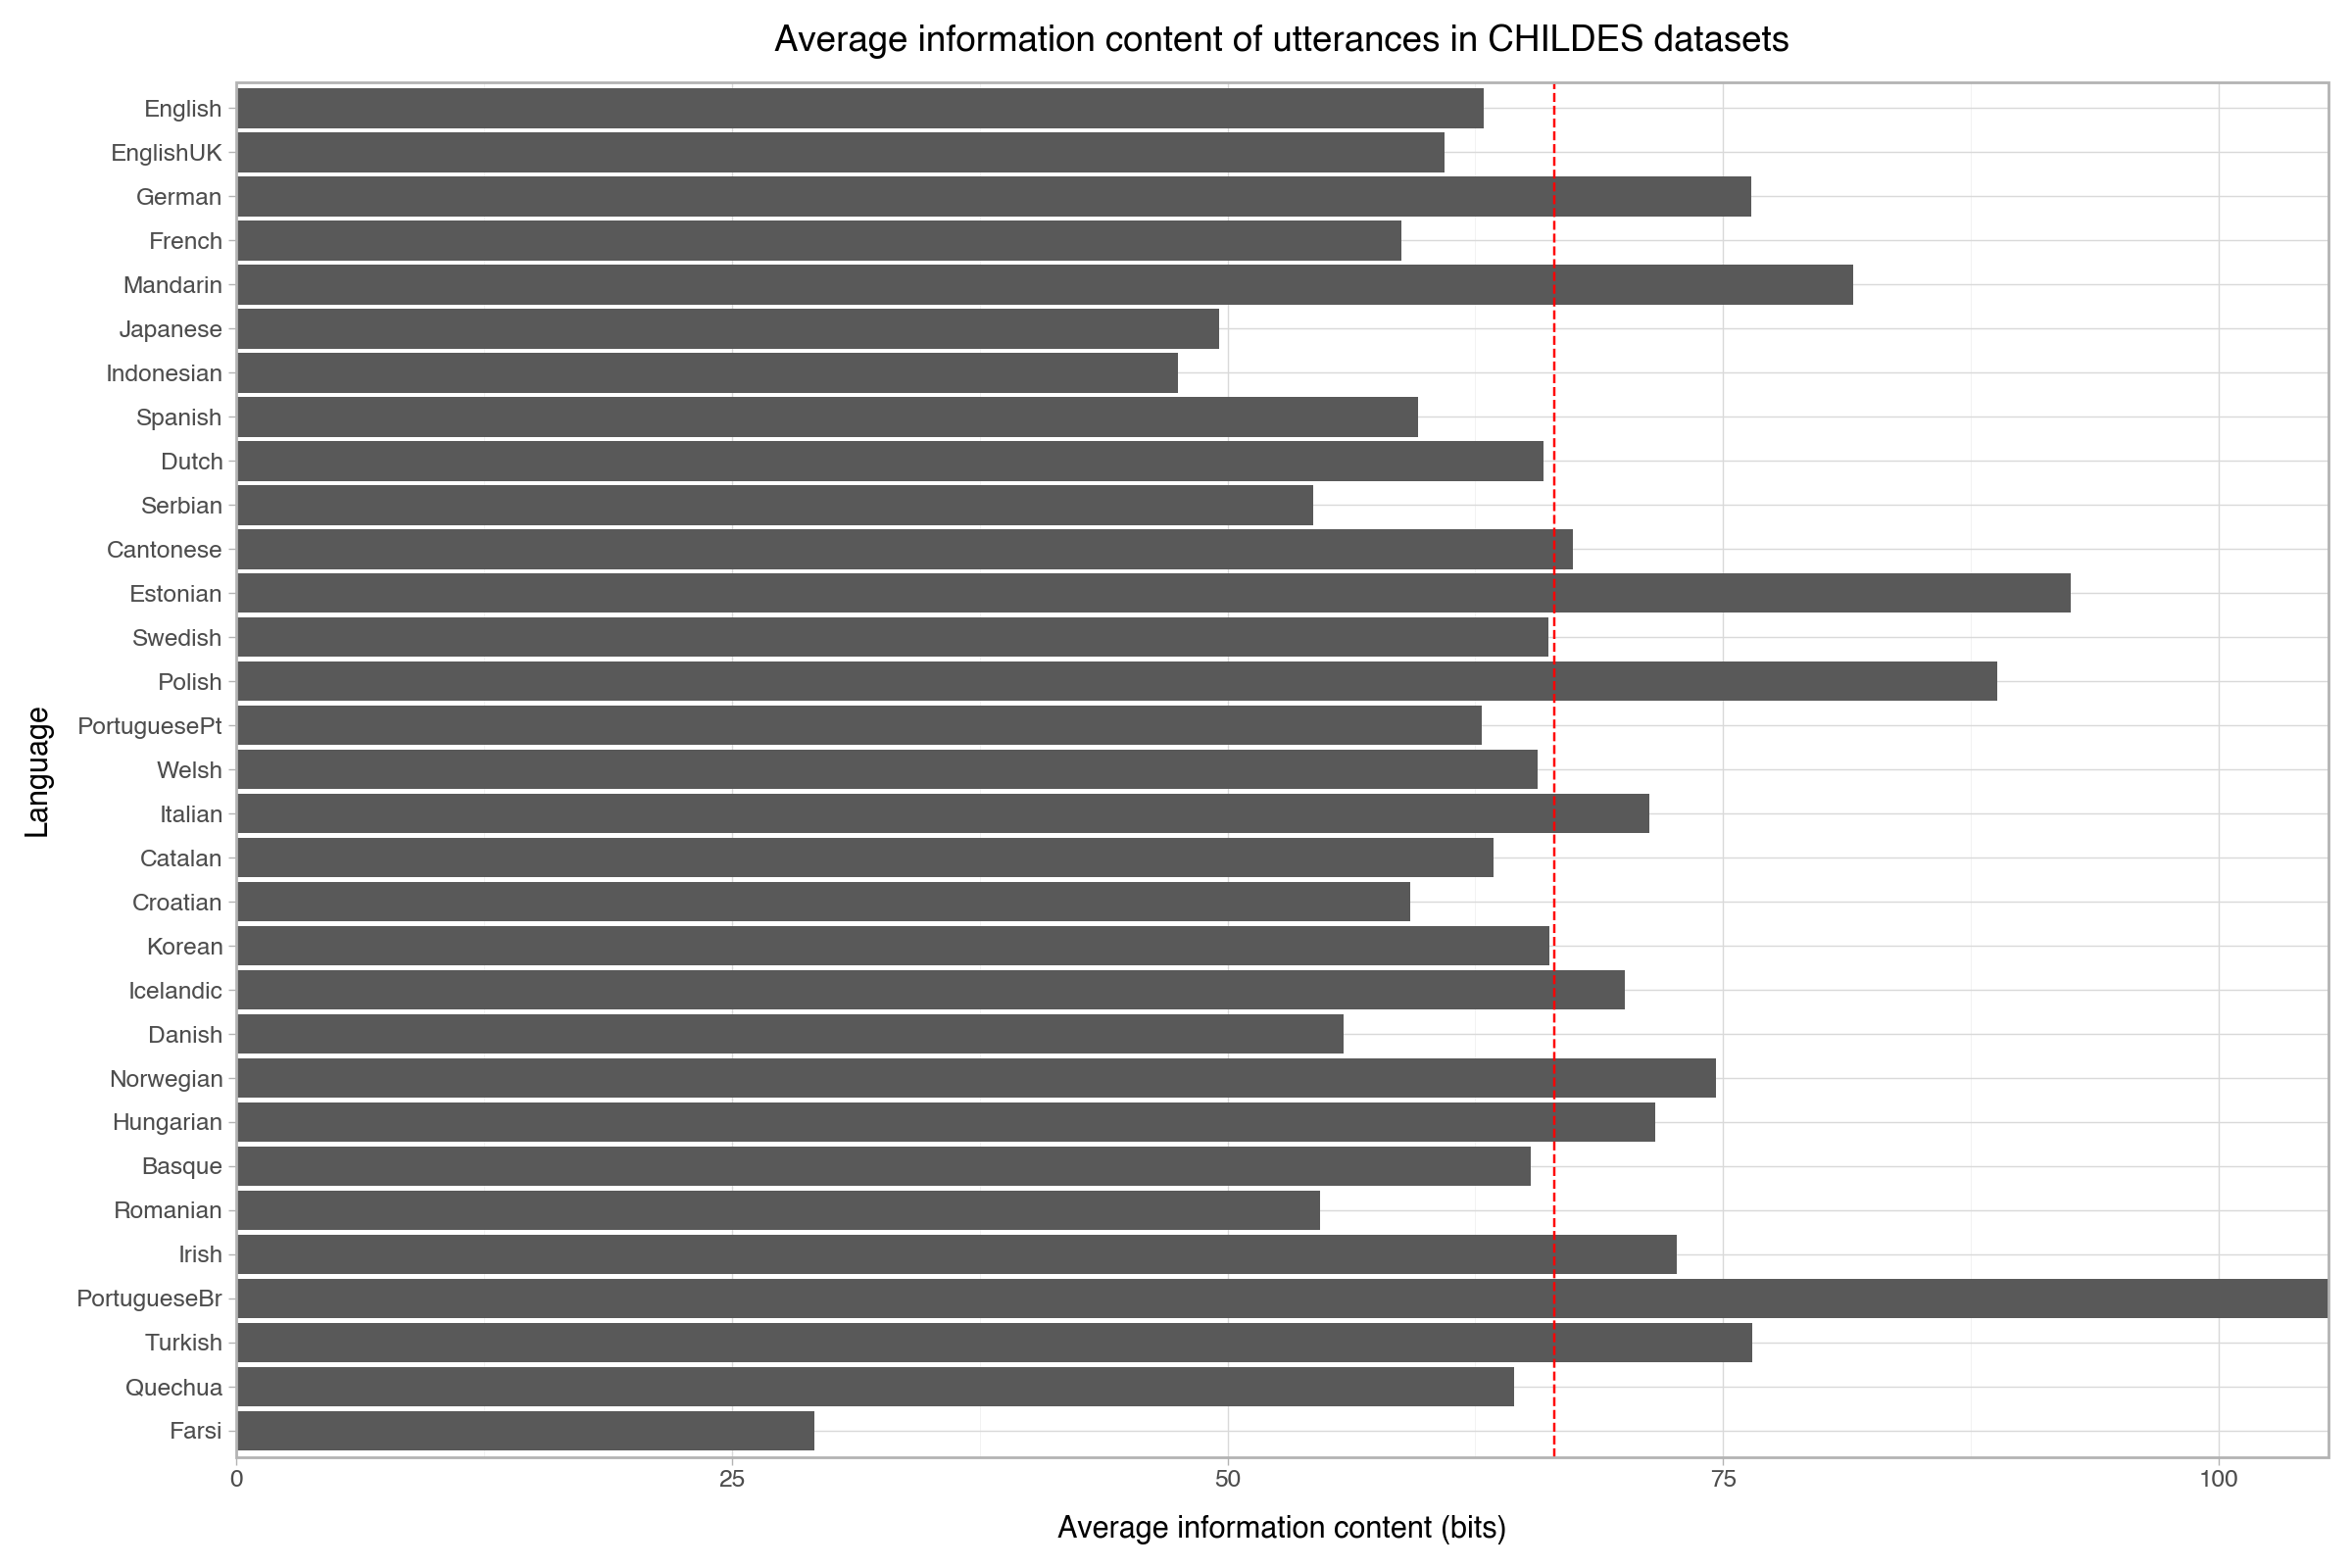

In [123]:
# Plot average information content of utterances in each language
properties['average_information_content'] = [np.mean(information_content[language]) for language in properties.language]

p = (p9.ggplot(properties.reset_index(), p9.aes(x='language', y='average_information_content'))
        + p9.geom_bar(stat='identity')
        + p9.geom_hline(yintercept=properties['average_information_content'].mean(), linetype='dashed', color='red')
        + p9.scale_y_continuous(limits=(0, None), expand=(0, 0))
        + p9.coord_flip()
        + p9.theme(figure_size=(12, 8))
        + p9.ggtitle('Average information content of utterances in CHILDES datasets')
        + p9.xlab('Language')
        + p9.ylab('Average information content (bits)')
    )

p.show()


## Age Analysis

/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/CorpusPhonemizers/env/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning:

stat_ydensity : Removed 348267 rows containing non-finite values.



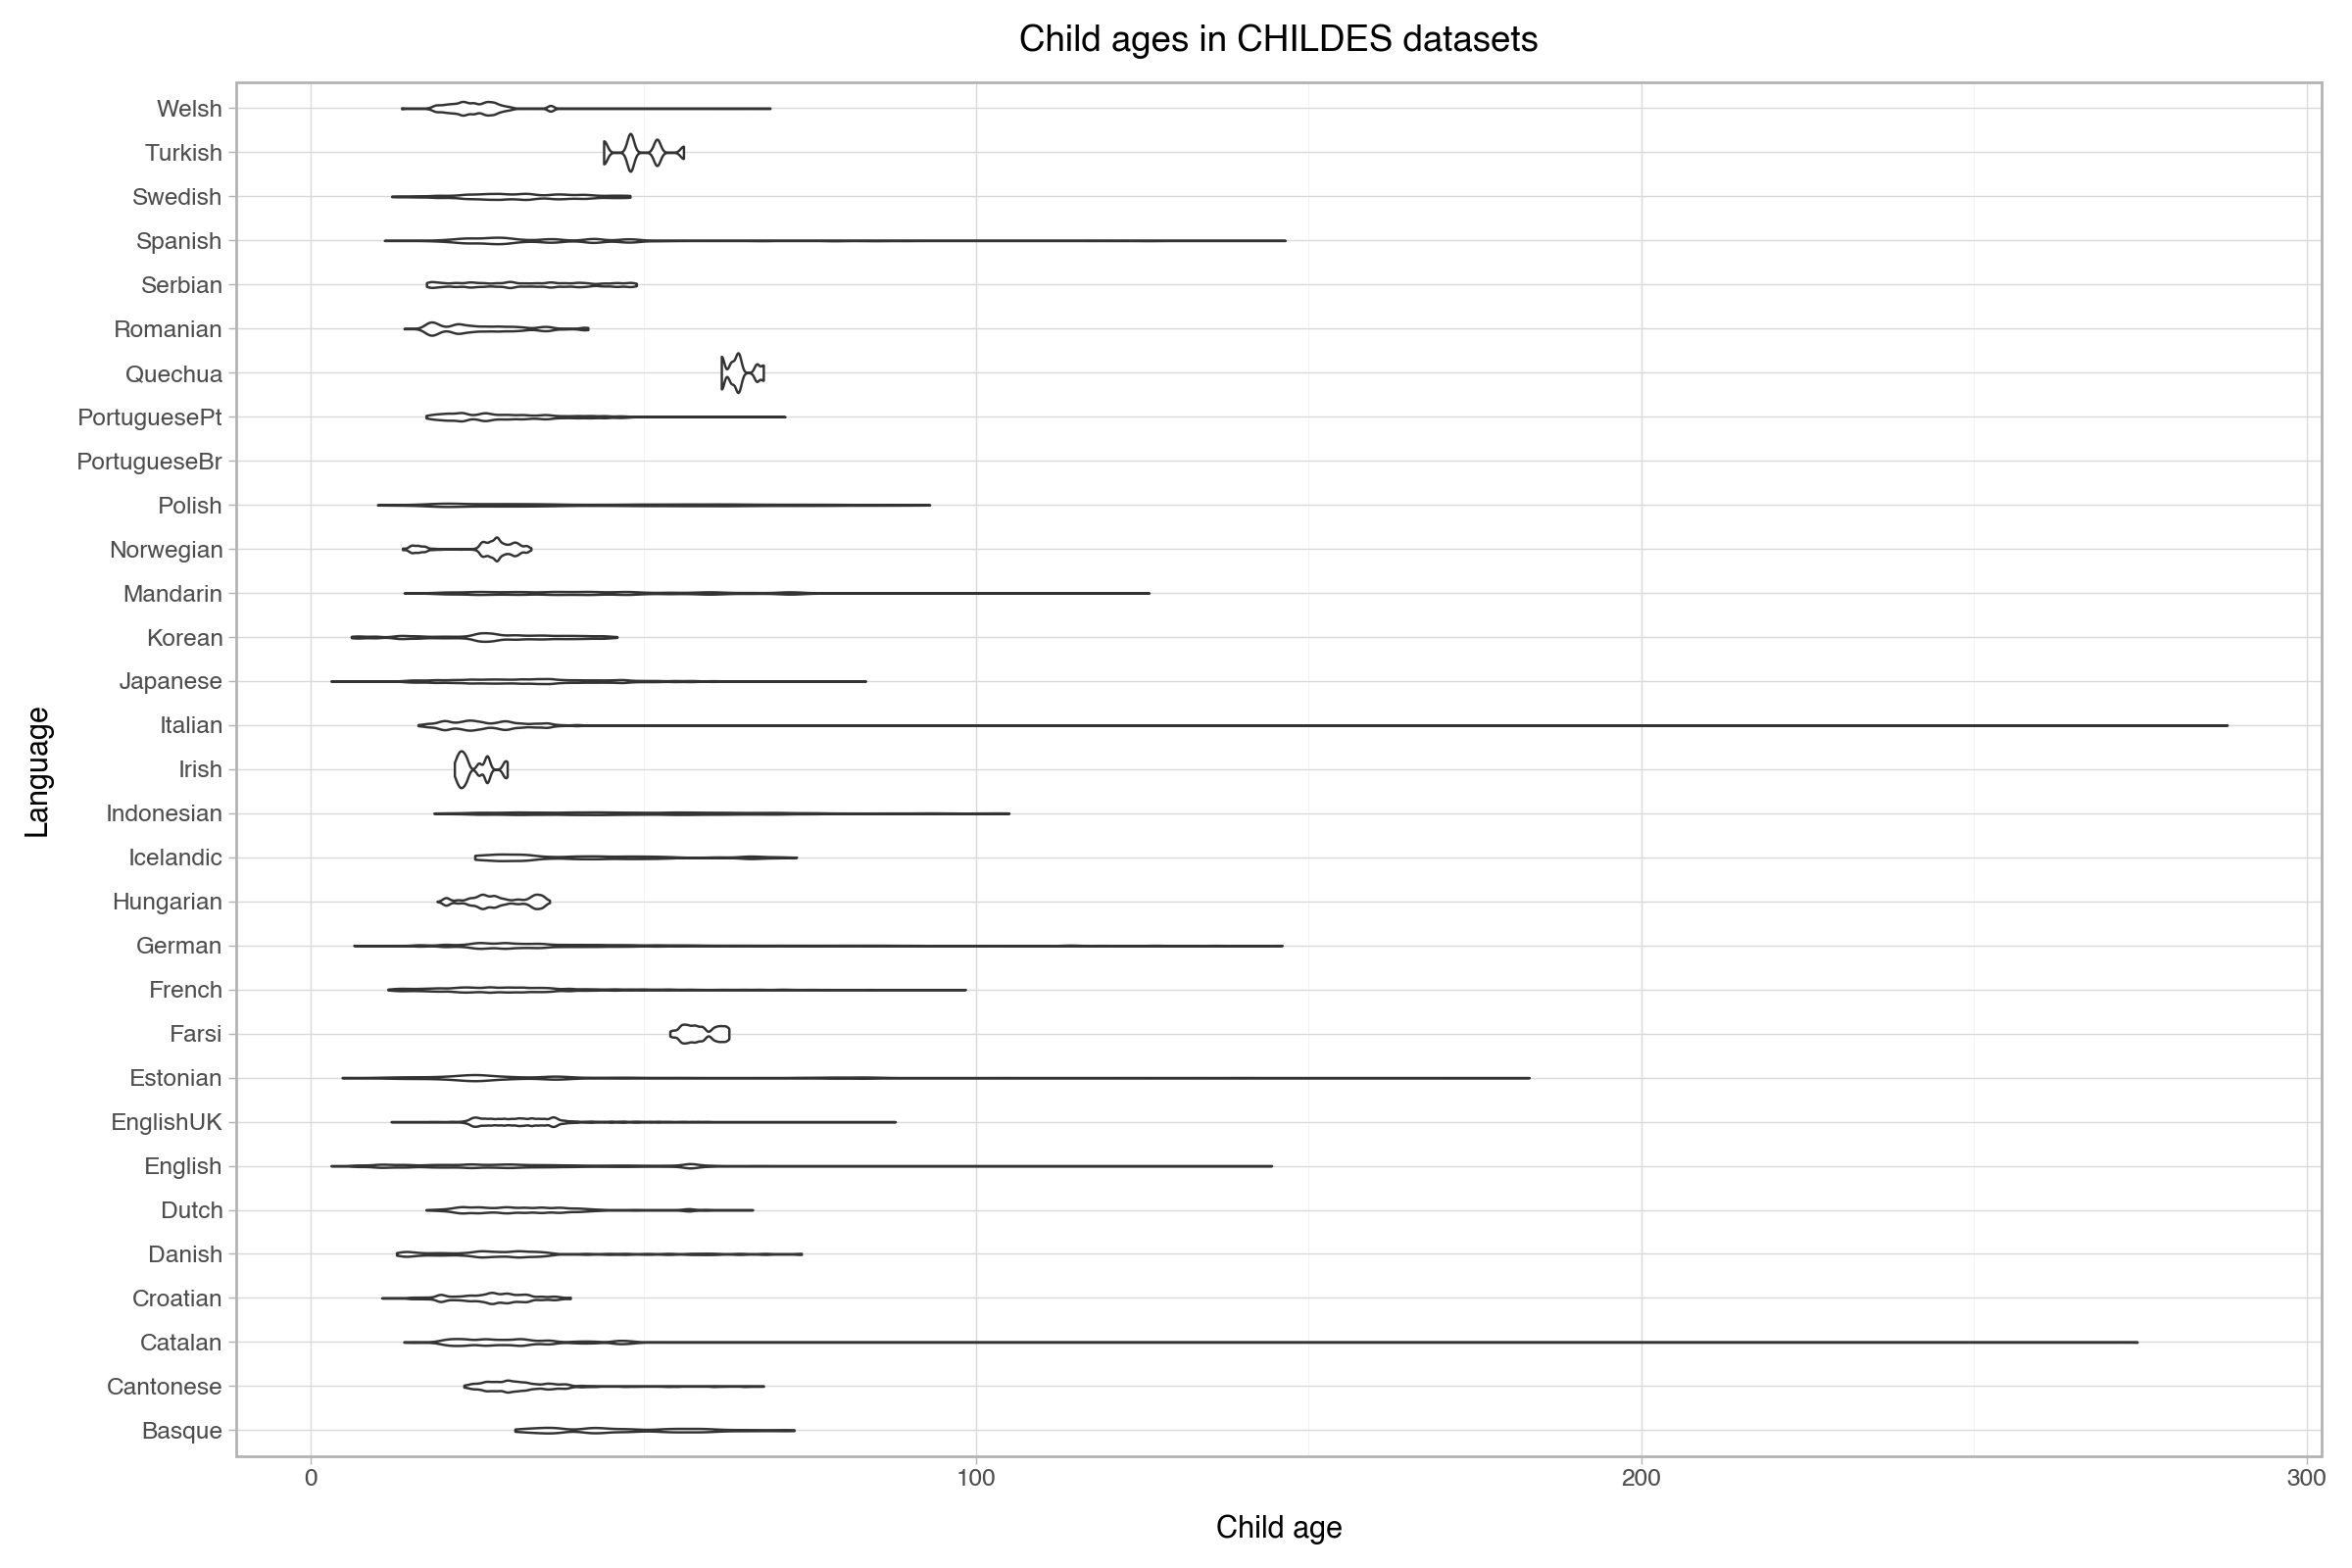

In [165]:
# Plot violin plot of child ages in each language
ages = {language : dataset['target_child_age'] for language, dataset in datasets.items()}

ages = pd.DataFrame({'language': [language for language in ages for _ in ages[language]],
                                'age': [age for ages in ages.values() for age in ages]})

p = (p9.ggplot(ages, p9.aes(x='language', y='age'))
        + p9.geom_violin()
        + p9.coord_flip()
        + p9.theme(figure_size=(12, 8))
        + p9.ggtitle('Child ages in CHILDES datasets')
        + p9.xlab('Language')
        + p9.ylab('Child age (months)')
    )

p.show()

In [127]:
# For English, get 10 bins of equal size for target_child_age
english = pd.DataFrame(datasets['English'])
english['target_child_age'] = english['target_child_age'].astype(float)
english['age_bin'] = pd.qcut(english['target_child_age'], 10)
age_bins = english['age_bin'].unique()
age_bins = age_bins.sort_values()


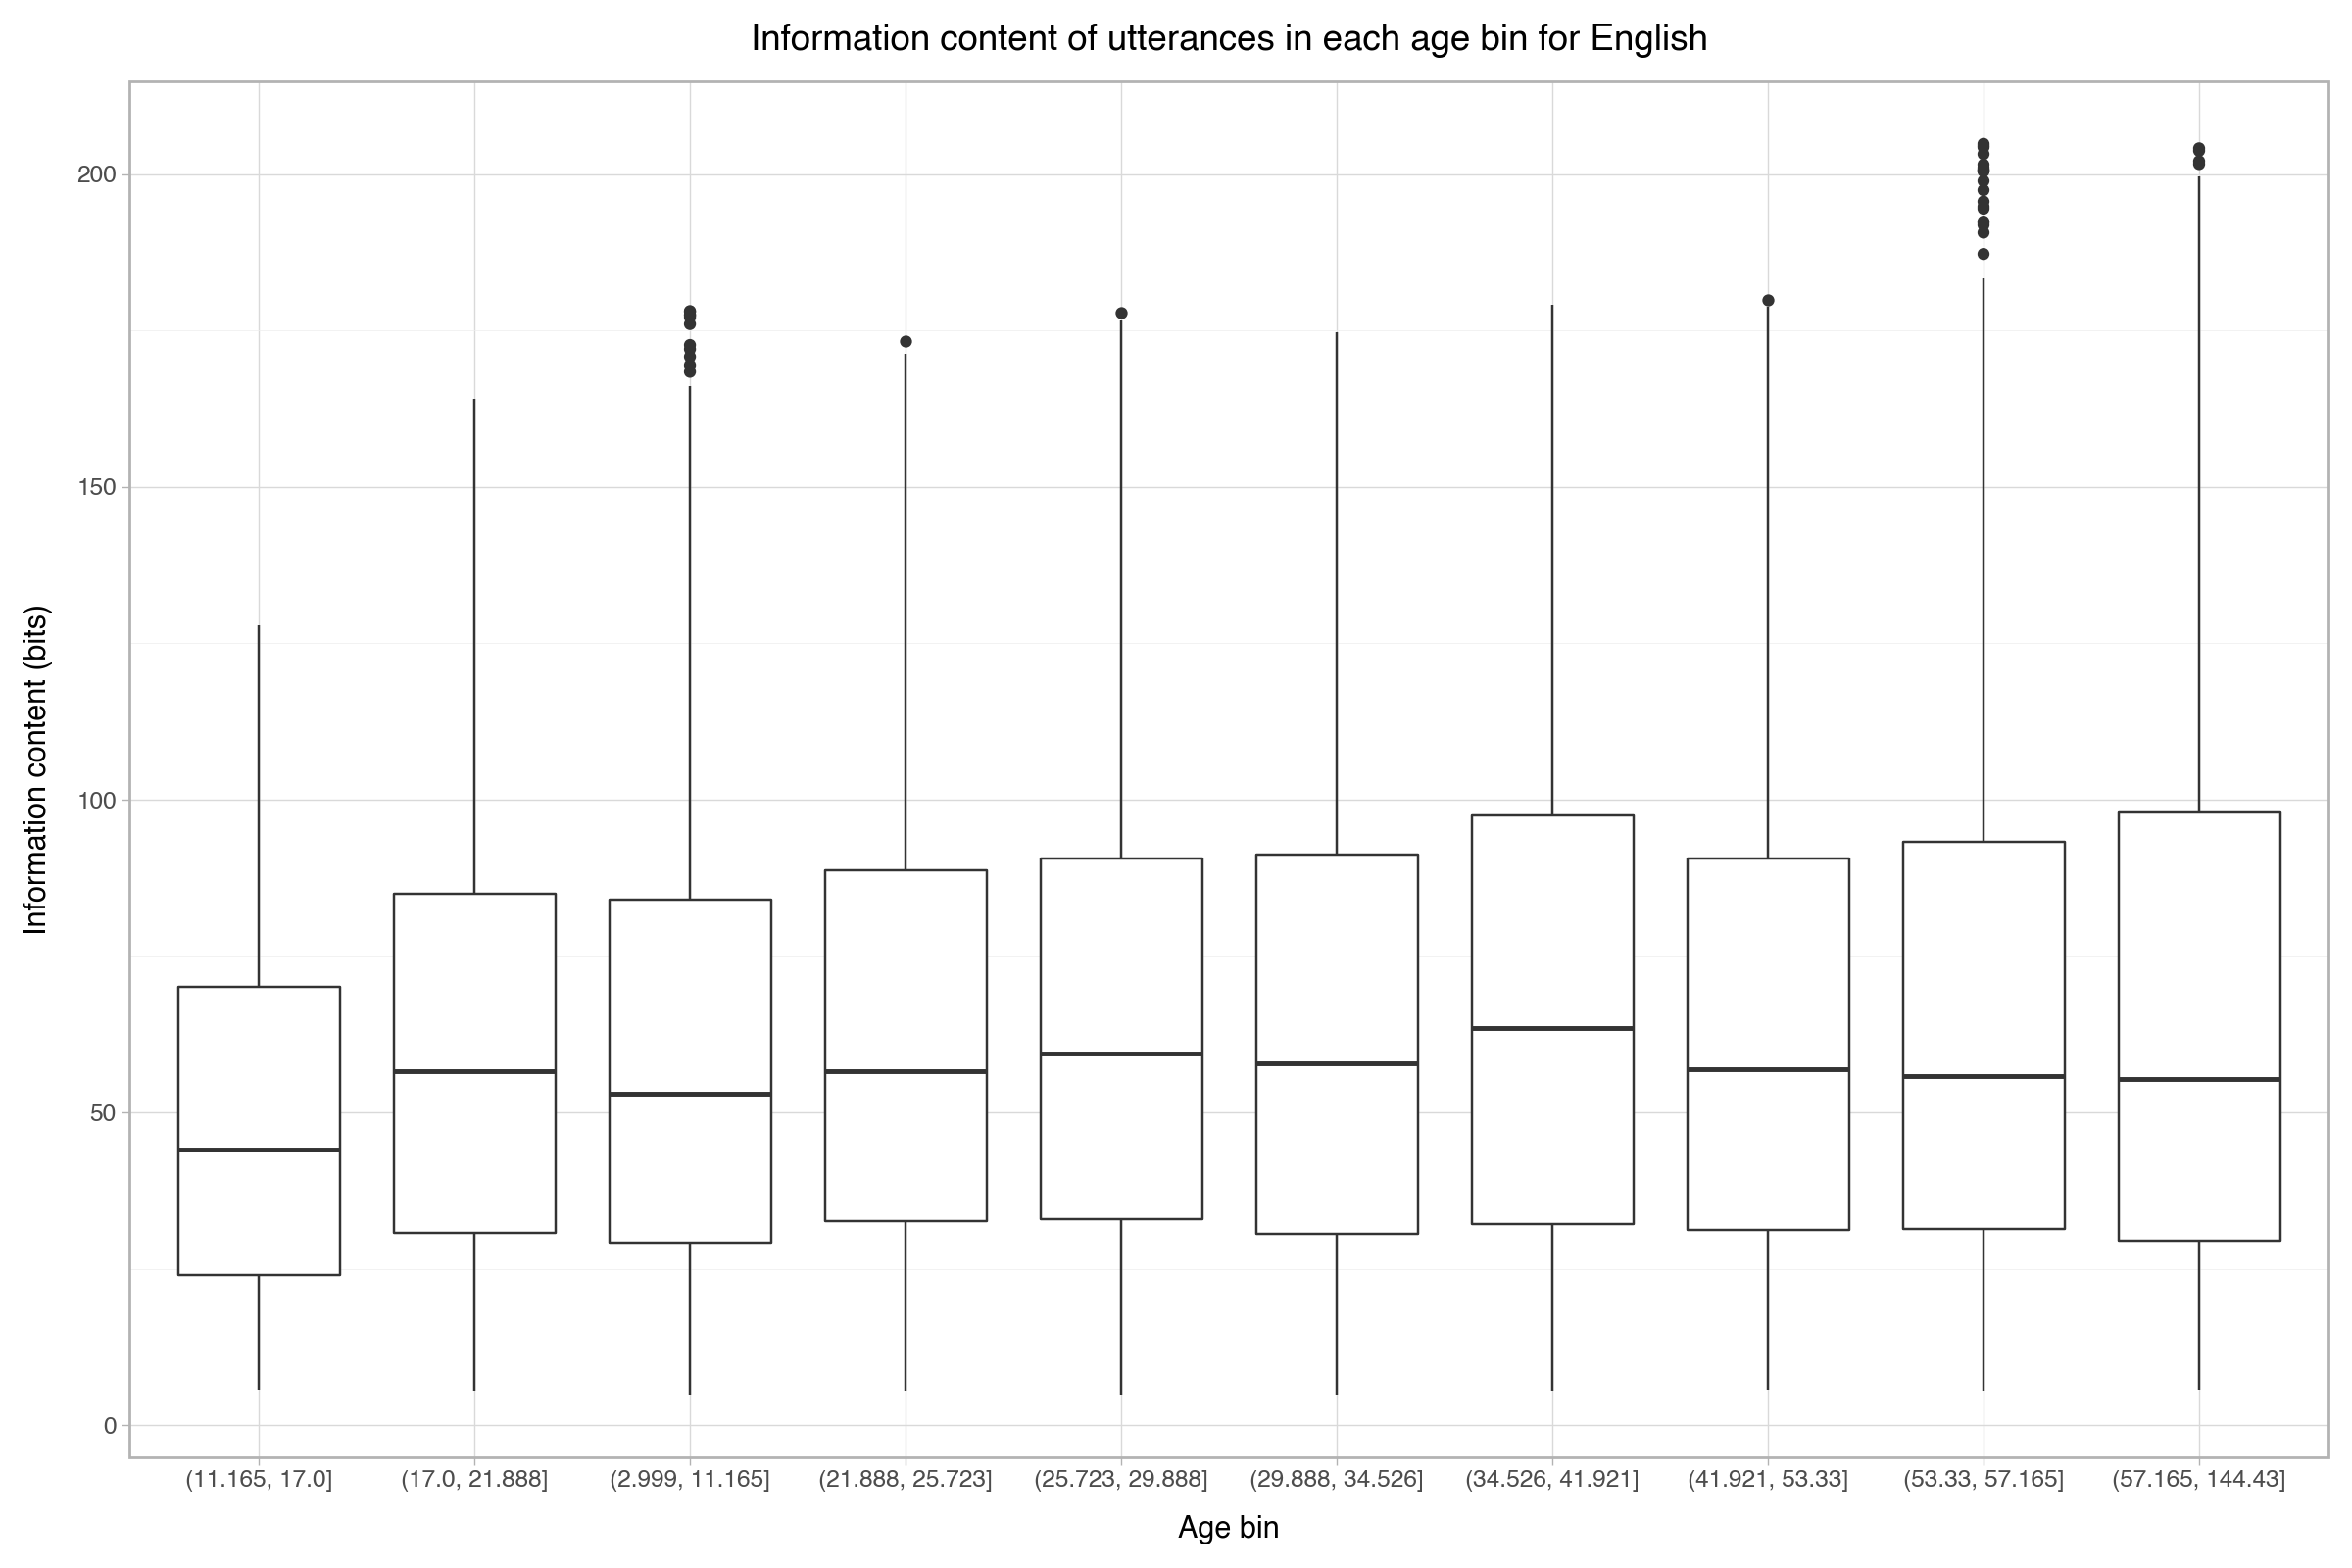

In [149]:
# Calculate the information content of each utterance in each age bin
information_content = {}
for age_bin in age_bins:
    lines = list(english[english['age_bin'] == age_bin]['phonemized_utterance'])
    lines = [line.replace(' WORD_BOUNDARY', '') for line in lines]
    np.random.shuffle(lines)
    lines = lines[:1000]
    information = [word_information(line, 'English') for line in lines]
    if len(information) > 0:
        information_content[age_bin] = information

# Remove top 5% of information content values for each age bin
for age_bin in information_content:
    percentile = np.percentile(information_content[age_bin], 95)
    information_content[age_bin] = [i for i in information_content[age_bin] if i <= percentile]

information_content = pd.DataFrame({'age_bin': [str(age_bin) for age_bin in information_content for _ in information_content[age_bin]],
                                    'information': [info for infos in information_content.values() for info in infos]})

# Sort by age_bin
information_content['age_bin'] = pd.Categorical(information_content['age_bin'], categories=age_bins, ordered=True)

p = (p9.ggplot(information_content, p9.aes(x='age_bin', y='information'))
        + p9.geom_boxplot()
        #+ p9.coord_flip()
        + p9.theme(figure_size=(12, 8))
        + p9.ggtitle('Information content of utterances in each age bin for English')
        + p9.xlab('Age bin')
        + p9.ylab('Information content (bits)')
    )

p.show()

In [21]:
# Plot averages with error bars

information_content_summary = information_content.groupby('age_bin').agg({'information': ['mean', 'std']}).reset_index()
# Drop level but don't lose "age_bin" column
information_content_summary.columns = information_content_summary.columns.droplevel(0)
information_content_summary.columns = ['age_bin', 'mean', 'std']

p = (p9.ggplot(information_content_summary, p9.aes(x='age_bin', y='mean'))
        + p9.geom_bar(stat='identity')
        + p9.geom_errorbar(p9.aes(ymin='mean - std', ymax='mean + std'), width=0.2)
        + p9.coord_flip()
        + p9.theme(figure_size=(12, 8))
        + p9.ggtitle('Information content of utterances in each age bin for English')
        + p9.xlab('Age bin')
        + p9.ylab('Information content (bits)')
    )

p.show()

# plt.figure(figsize=(10, 5))
# averages = {age_bin : np.mean(information_content[age_bin]) for age_bin in information_content}
# sns.barplot(x=list(averages.keys()), y=list(averages.values()))
# plt.xticks(rotation=90)
# plt.ylabel('Average information content (bits)')
# plt.title('Average information content of utterances in each age bin for English')
# plt.show()


NameError: name 'information_content' is not defined

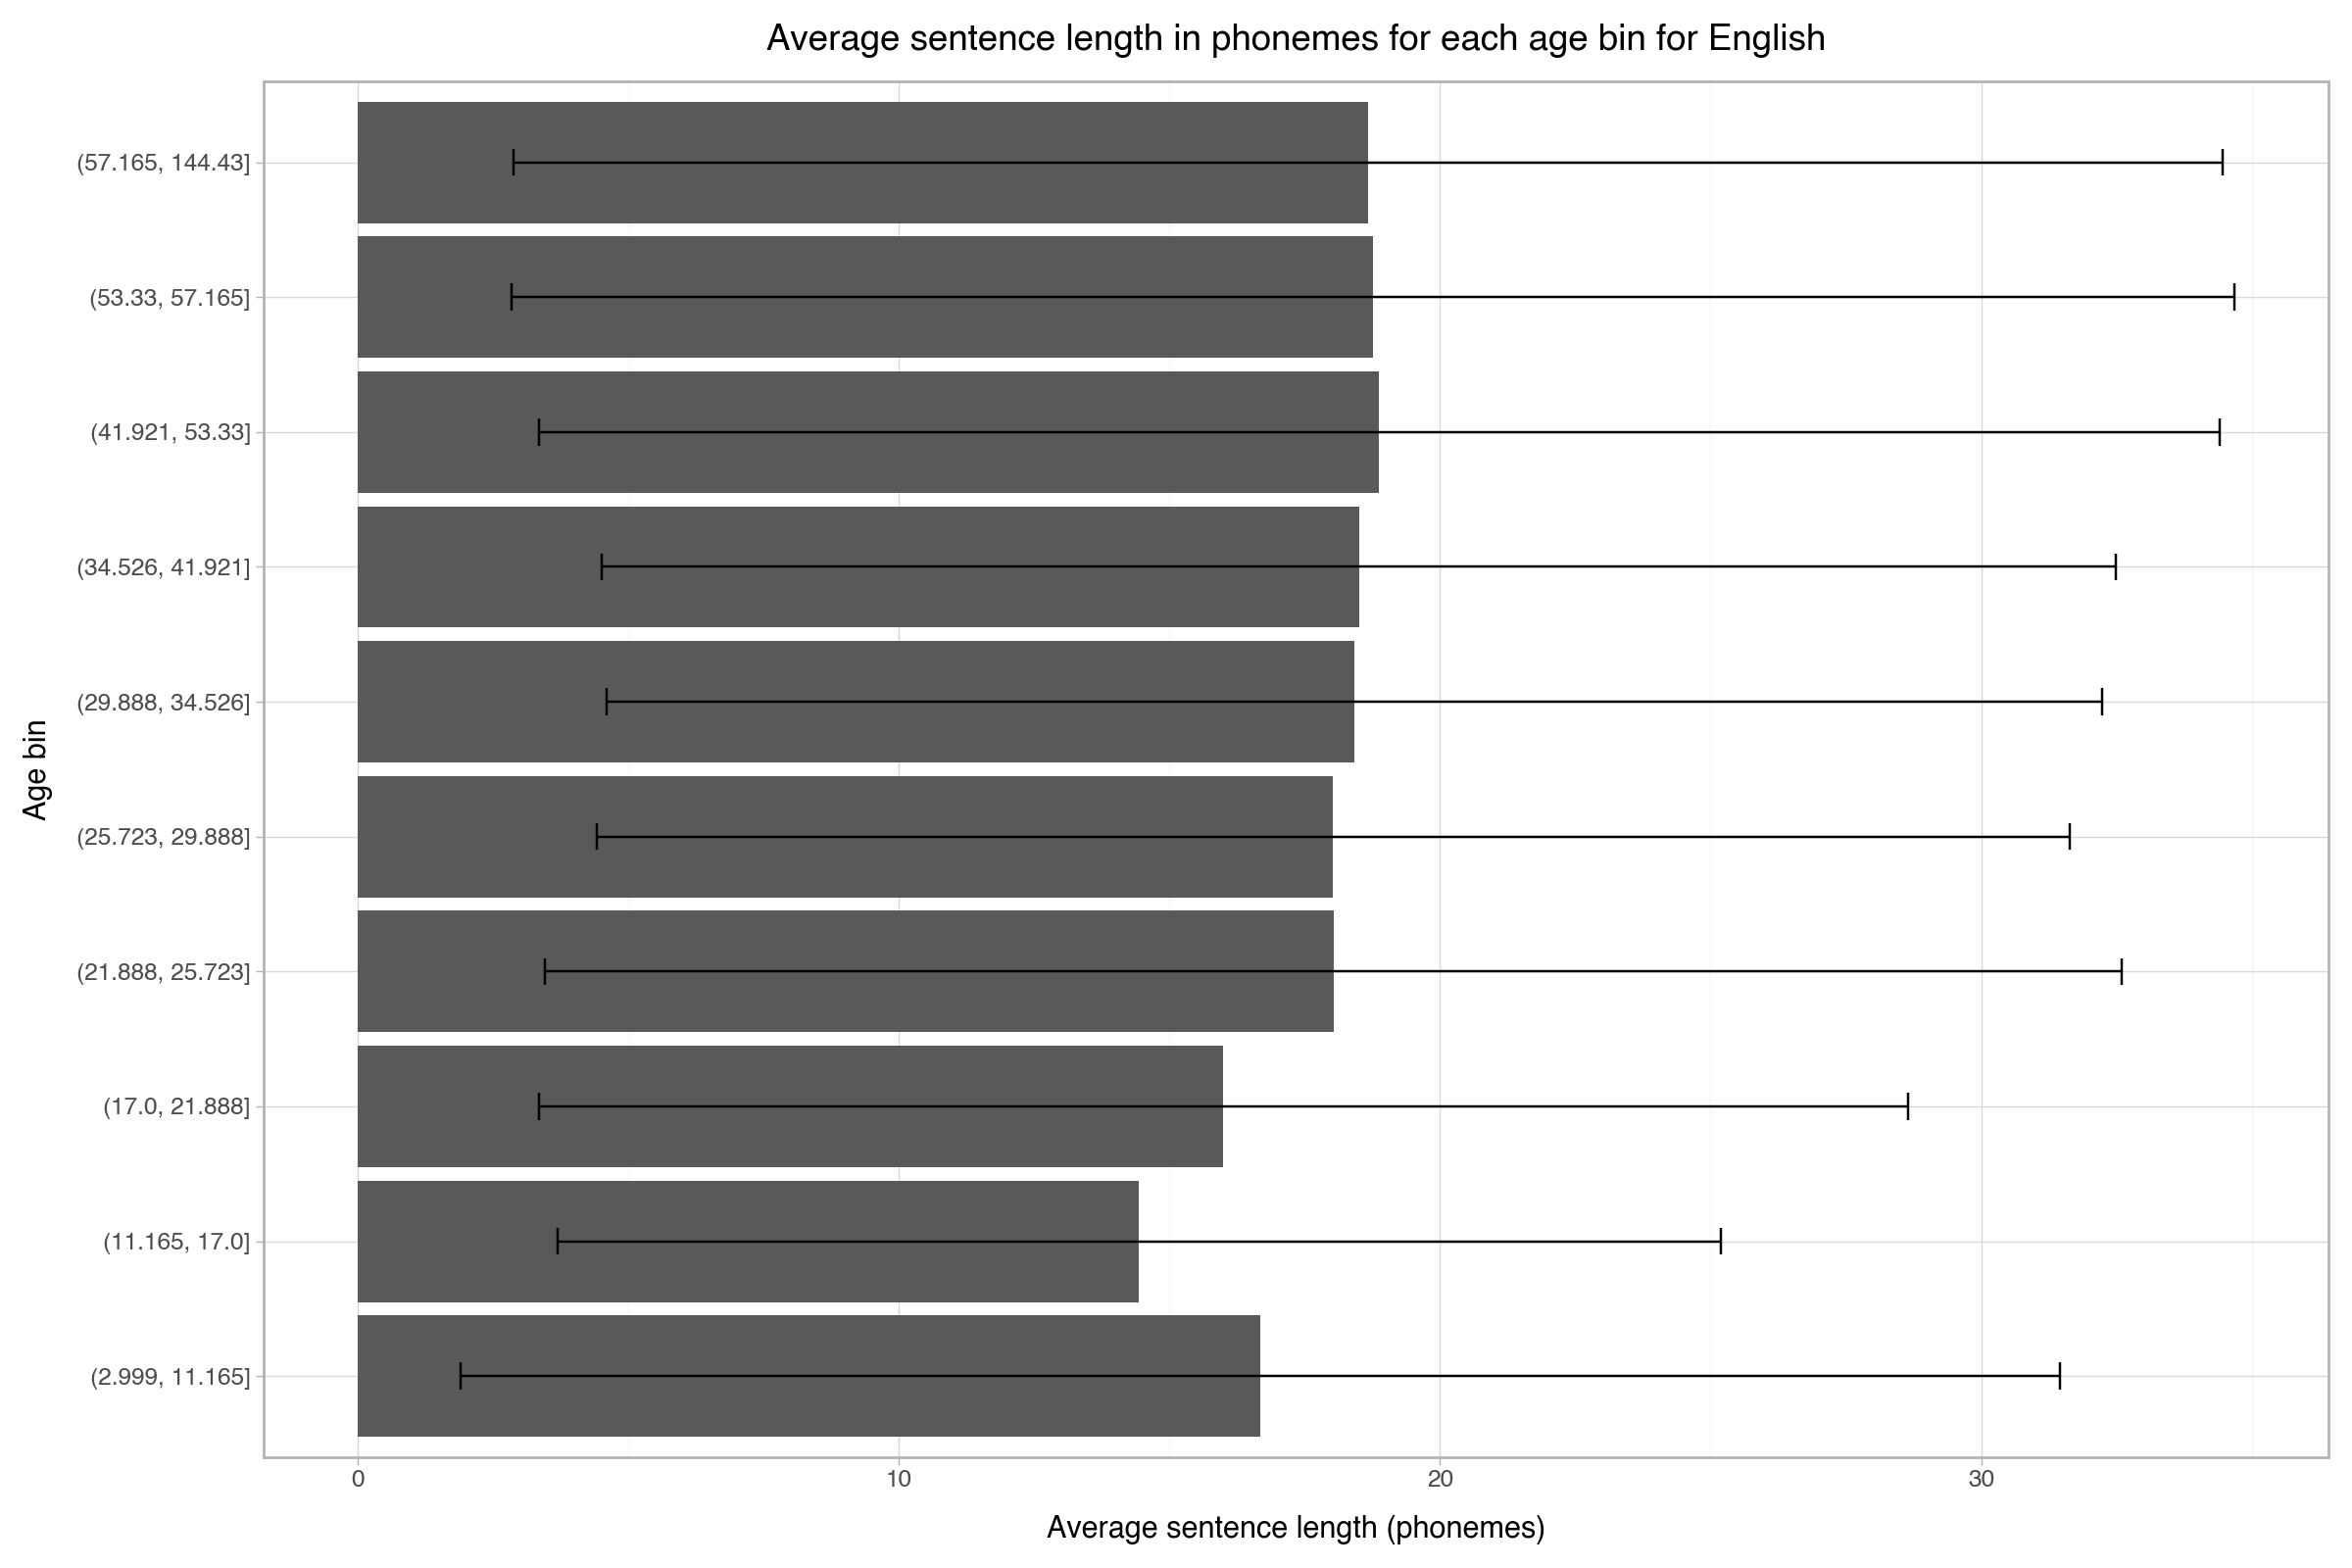

In [162]:
# Get average sentence length in phonemes for each bin
sentence_lengths = pd.DataFrame(columns=['age_bin', 'average_sentence_length', 'std'])
sentence_lengths.set_index('age_bin', inplace=True)
sentence_lengths.index.name = 'age_bin'

for age_bin in age_bins:
    lines = list(english[english['age_bin'] == age_bin]['phonemized_utterance'])
    n_utterances = len(lines)
    if n_utterances == 0:
        continue
    phoneme_counts = [len(utterance.split(' ')) for utterance in lines]
    average_sentence_length = np.mean(phoneme_counts)
    std = np.std(phoneme_counts)
    sentence_lengths.loc[age_bin] = [average_sentence_length, std]

# plt.figure(figsize=(10, 5))
# sns.barplot(data=sentence_lengths, x=sentence_lengths.index, y='average_sentence_length')
# plt.xticks(rotation=90)
# plt.ylabel('Average sentence length (phonemes)')
# plt.title('Average sentence length in phonemes for each age bin for English')
# plt.show()

p = (p9.ggplot(sentence_lengths.reset_index(), p9.aes(x='age_bin', y='average_sentence_length'))
        + p9.geom_bar(stat='identity')
        + p9.geom_errorbar(p9.aes(ymin='average_sentence_length - std', ymax='average_sentence_length + std'), width=0.2)
        + p9.coord_flip()
        + p9.theme(figure_size=(12, 8))
        + p9.ggtitle('Average sentence length in phonemes for each age bin for English')
        + p9.xlab('Age bin')
        + p9.ylab('Average sentence length (phonemes)')
    )

p.show()
